In [ ]:
# Configuración inicial para organizar resultados
import os

# Crear estructura de directorios para resultados
base_output_dir = "../Output/Results_Clusters"
figures_dir = os.path.join(base_output_dir, "Figures")
stats_dir = os.path.join(base_output_dir, "Statistics")
reports_dir = os.path.join(base_output_dir, "Reports")

# Crear subdirectorios para análisis de 2 y 3 clusters
stats_k2_dir = os.path.join(stats_dir, "k2_analysis")
stats_k3_dir = os.path.join(stats_dir, "k3_analysis")

for directory in [base_output_dir, figures_dir, stats_dir, reports_dir, stats_k2_dir, stats_k3_dir]:
    os.makedirs(directory, exist_ok=True)

print("Estructura de directorios creada:")
print(f"- Base: {base_output_dir}")
print(f"- Figuras: {figures_dir}")
print(f"- Estadísticas: {stats_dir}")
print(f"- Reportes: {reports_dir}")


# Clustering Analysis
This notebook performs clustering analysis on survey data using K-Means for clustering and UMAP for visualization. The analysis creates two key visualizations:

1. K-Means clustering directly on the data, then visualized with UMAP
2. Program type distribution visualized with UMAP

## 1. Import Libraries and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Set global plotting parameters
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Loading and Preprocessing

In [2]:
# Load data
def load_and_preprocess_data():
    # Load data with clusters already generated
    data = pd.read_stata("../Data/V1_qualflags_analysis2_clustered.dta")
    
    # Get variable labels if needed
    try:
        _, meta = pyreadstat.read_dta("../Data/V1_qualflags_analysis2_clustered.dta")
        variable_labels = dict(zip(data.columns, meta.column_labels))
    except:
        variable_labels = {}
        print("Warning: Could not read variable labels from data file")
    
    # Save program types for later comparison
    program_types = data['program'].copy() if 'program' in data.columns else None
    
    # Create dummy variables (excluding program and cluster columns)
    cluster_cols = [col for col in data.columns if 'cluster_' in col.lower()]
    program_cols = [col for col in data.columns if 'program' in col.lower()]
    exclude_cols = cluster_cols + program_cols
    
    # Create a subset of data for dummy variables (excluding clusters and program info)
    data_for_dummies = data.drop(columns=exclude_cols, errors='ignore')
    
    # Select key variables (p_* variables) for clustering analysis
    p_vars = [col for col in data_for_dummies.columns if col.startswith('p_')]
    
    # If p_vars is empty, use all columns
    if not p_vars:
        p_vars = data_for_dummies.columns.tolist()
    
    # Filter to include only p_vars
    data_for_dummies = data_for_dummies[p_vars]
    
    # Create dummy variables for categorical columns
    data_dummies = pd.get_dummies(data_for_dummies)
    
    # Clean column names
    new_cols = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_') 
                for col in data_dummies.columns]
    data_dummies.columns = new_cols
    
    # Handle missing values
    # Fill numeric columns with median
    numeric_cols = data_dummies.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        data_dummies[col] = data_dummies[col].fillna(data_dummies[col].median())
    
    # Fill non-numeric columns with mode
    non_numeric_cols = data_dummies.select_dtypes(exclude=['float64', 'int64']).columns
    for col in non_numeric_cols:
        if not data_dummies[col].mode().empty:
            data_dummies[col] = data_dummies[col].fillna(data_dummies[col].mode()[0])
        else:
            data_dummies[col] = data_dummies[col].fillna(0)
    
    # Standardize features for scaling
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_dummies)
    
    print(f"Original data shape: {data.shape}")
    print(f"Processed data shape: {data_dummies.shape}")
    
    # Return cluster columns separately for later use
    return data, data_dummies, data_scaled, program_types, variable_labels, cluster_cols

# Load and preprocess data
data, data_dummies, data_scaled, program_types, variable_labels, cluster_cols = load_and_preprocess_data()

Original data shape: (1125, 1162)
Processed data shape: (1125, 184)


## 3. Perform K-Means Clustering Directly on Data

In [3]:
# Perform K-Means clustering on the scaled data
# def perform_kmeans_clustering(data_scaled, n_clusters_list=[2, 3]):
#     clustering_results = {}
    
#     for n_clusters in n_clusters_list:
#         # Apply K-Means clustering
#         kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#         cluster_labels = kmeans.fit_predict(data_scaled)
        
#         # Calculate silhouette score
#         silhouette = silhouette_score(data_scaled, cluster_labels)
        
#         # Store results
#         clustering_results[n_clusters] = {
#             'labels': cluster_labels,
#             'model': kmeans,
#             'silhouette': silhouette
#         }
        
#         print(f"\nK-Means clustering with {n_clusters} clusters:")
#         print(f"Silhouette Score: {silhouette:.3f}")
#         print(f"Cluster distribution:")
#         print(pd.Series(cluster_labels).value_counts().sort_index())
    
#     return clustering_results


# Perform clustering for both k=2 and k=3
#clustering_results = perform_kmeans_clustering(data_scaled)

def extract_clusters_from_data(data):
    """
    Extract cluster assignments from specific columns in the data
    and create a dictionary compatible with the rest of the code
    """
    clustering_results = {}
    
    # Map the cluster columns to their respective number of clusters
    cluster_mapping = {
        'cluster_ch': 2,       # 2 clusters (CH method)
        'cluster_elbow': 4,    # 4 clusters (Elbow method)
        'cluster_gap': 8       # 8 clusters (Gap method)
    }
    
    # Save original cluster assignments and create zero-based indexing
    for col_name, n_clusters in cluster_mapping.items():
        if col_name in data.columns:
            print(f"Processing {col_name} with {n_clusters} clusters")
            
            # Convert categorical to numeric if needed
            if hasattr(data[col_name], 'cat'):
                print(f"  Converting {col_name} from categorical to numeric")
                # Convert categorical to numeric
                original_labels = data[col_name].cat.codes.values + 1  # +1 because cat.codes is 0-based
                labels = data[col_name].cat.codes.values  # Already 0-based
            else:
                # Save original labels (1-based from Stata)
                original_labels = data[col_name].astype(int).values
                # Convert to zero-based indexing (scikit-learn style)
                labels = original_labels - 1
            
            # Create a dummy KMeans model with correct number of clusters
            dummy_model = KMeans(n_clusters=n_clusters, random_state=42)
            dummy_model.labels_ = labels
            
            # Store in results with method name
            method_name = col_name.replace('cluster_', '')
            clustering_results[n_clusters] = {
                'labels': labels,
                'original_labels': original_labels,
                'model': dummy_model,
                'column': col_name,
                'method': method_name
            }
            
            # Print distribution of clusters
            print(f"  Distribution of {col_name}:")
            print(pd.Series(original_labels).value_counts().sort_index())
    
    # Create a 3-cluster solution from the Elbow method's 4-cluster solution
    # by merging clusters 3 and 4 (which are 2 and 3 in zero-based indexing)
    if 4 in clustering_results:
        print("\nCreating 3-cluster solution from Elbow method (4 clusters)")
        
        labels_4 = clustering_results[4]['labels']
        original_labels_4 = clustering_results[4]['original_labels']
        
        labels_3 = labels_4.copy()
        original_labels_3 = original_labels_4.copy()
        
        # Merge the last two clusters: map cluster_elbow=4 to cluster_3=3
        # In zero-based: map index 3 to index 2
        labels_3[labels_4 == 3] = 2  # Map cluster 3 (zero-based) to cluster 2
        # In one-based: map value 4 to value 3
        original_labels_3[original_labels_4 == 4] = 3  # Map cluster 4 to cluster 3
        
        # Create a dummy model for compatibility
        dummy_model = KMeans(n_clusters=3, random_state=42)
        dummy_model.labels_ = labels_3
        
        # Store in results
        clustering_results[3] = {
            'labels': labels_3,
            'original_labels': original_labels_3,
            'model': dummy_model,
            'column': 'cluster_elbow_derived',
            'method': 'elbow_derived'
        }
        
        print("  Distribution of new 3-cluster solution:")
        print(pd.Series(original_labels_3).value_counts().sort_index())
    
    return clustering_results

# Extract clusters from loaded data instead of performing new clustering
clustering_results = extract_clusters_from_data(data)

# Calculate silhouette scores for each clustering
for k, result in clustering_results.items():
    try:
        silhouette = silhouette_score(data_scaled, result['labels'])
        result['silhouette'] = silhouette
        print(f"Silhouette score for k={k} ({result.get('method', 'unknown')}): {silhouette:.3f}")
    except:
        result['silhouette'] = 0
        print(f"Could not calculate silhouette score for k={k}")

# Print final cluster information
print("\n==== SUMMARY OF LOADED CLUSTERS ====")
for k, result in clustering_results.items():
    print(f"\nCluster k={k} ({result.get('method', 'unknown')}):")
    print(f"Source: {result.get('column', 'unknown')}")
    print(f"Distribution: {pd.Series(result['original_labels']).value_counts().sort_index().to_dict()}")
    if 'silhouette' in result:
        print(f"Silhouette score: {result['silhouette']:.3f}")

Processing cluster_ch with 2 clusters
  Converting cluster_ch from categorical to numeric
  Distribution of cluster_ch:
1    466
2    659
Name: count, dtype: int64
Processing cluster_elbow with 4 clusters
  Converting cluster_elbow from categorical to numeric
  Distribution of cluster_elbow:
1    203
2    271
3    288
4    363
Name: count, dtype: int64
Processing cluster_gap with 8 clusters
  Converting cluster_gap from categorical to numeric
  Distribution of cluster_gap:
1    108
2    154
3    210
4    109
5    106
6    170
7    122
8    146
Name: count, dtype: int64

Creating 3-cluster solution from Elbow method (4 clusters)
  Distribution of new 3-cluster solution:
1    203
2    271
3    651
Name: count, dtype: int64
Silhouette score for k=2 (ch): 0.036
Silhouette score for k=4 (elbow): 0.028
Silhouette score for k=8 (gap): 0.016
Silhouette score for k=3 (elbow_derived): 0.017

==== SUMMARY OF LOADED CLUSTERS ====

Cluster k=2 (ch):
Source: cluster_ch
Distribution: {1: 466, 2: 659}

## 4. Apply UMAP for Visualization

In [4]:
# Apply UMAP for visualization
def apply_umap_for_visualization(data_scaled):
    # UMAP for dimensionality reduction (for visualization only)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(data_scaled)
    
    print(f"UMAP embedding shape: {embedding.shape}")
    return embedding

# Get UMAP embedding
umap_embedding = apply_umap_for_visualization(data_scaled)

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1125, 2)


## 5. Visualize Clusters with UMAP

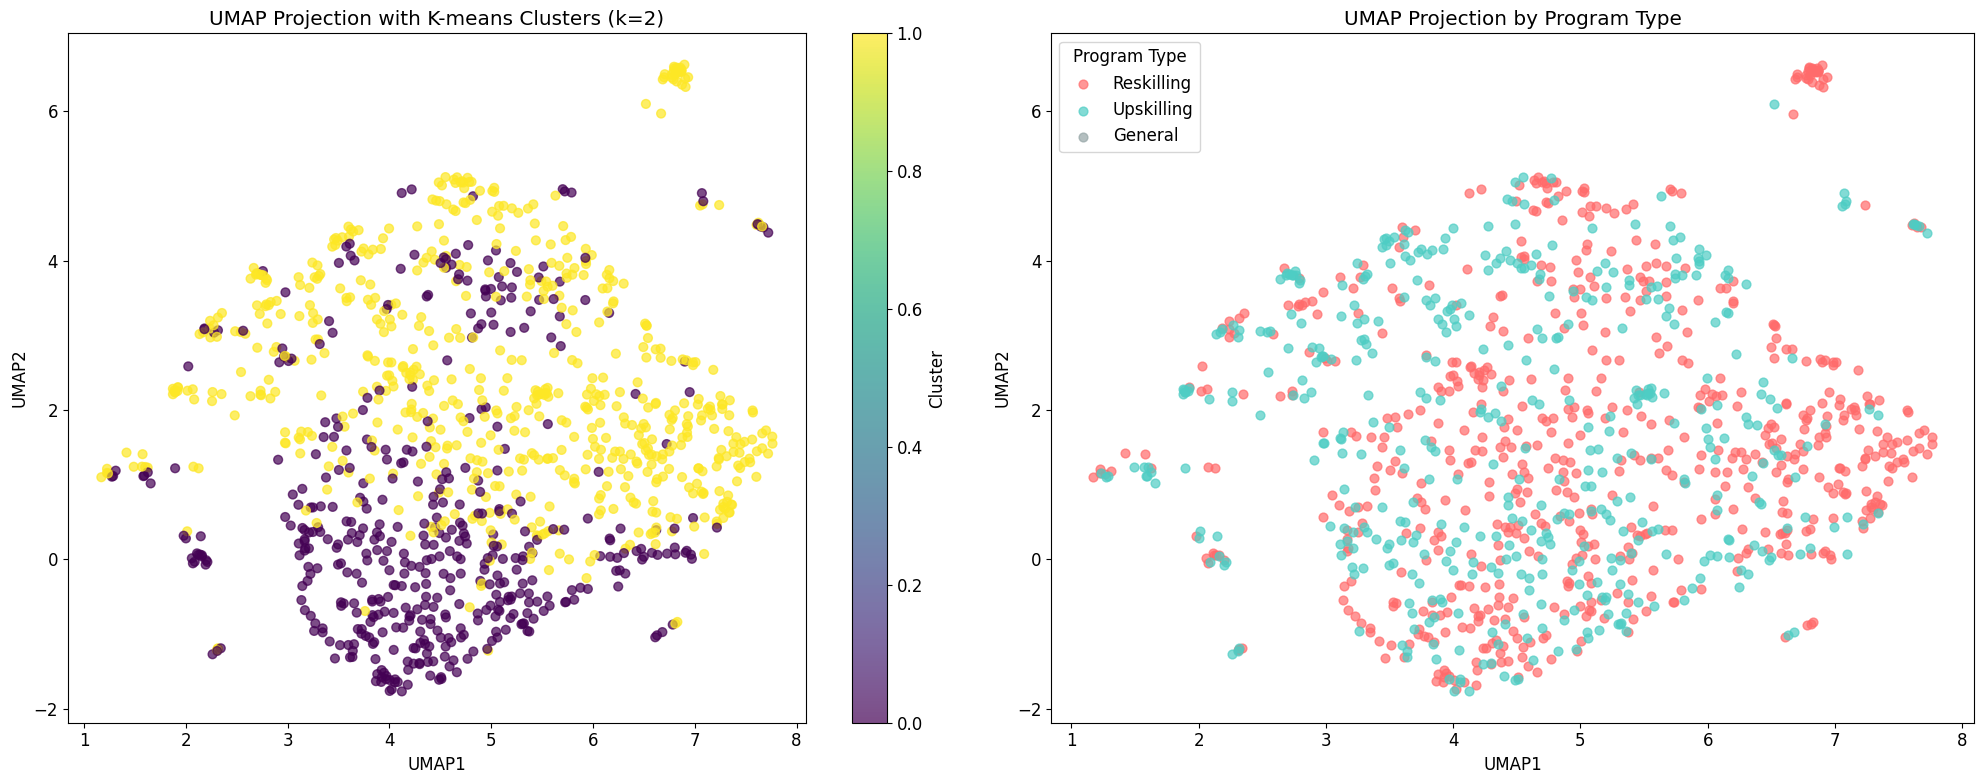

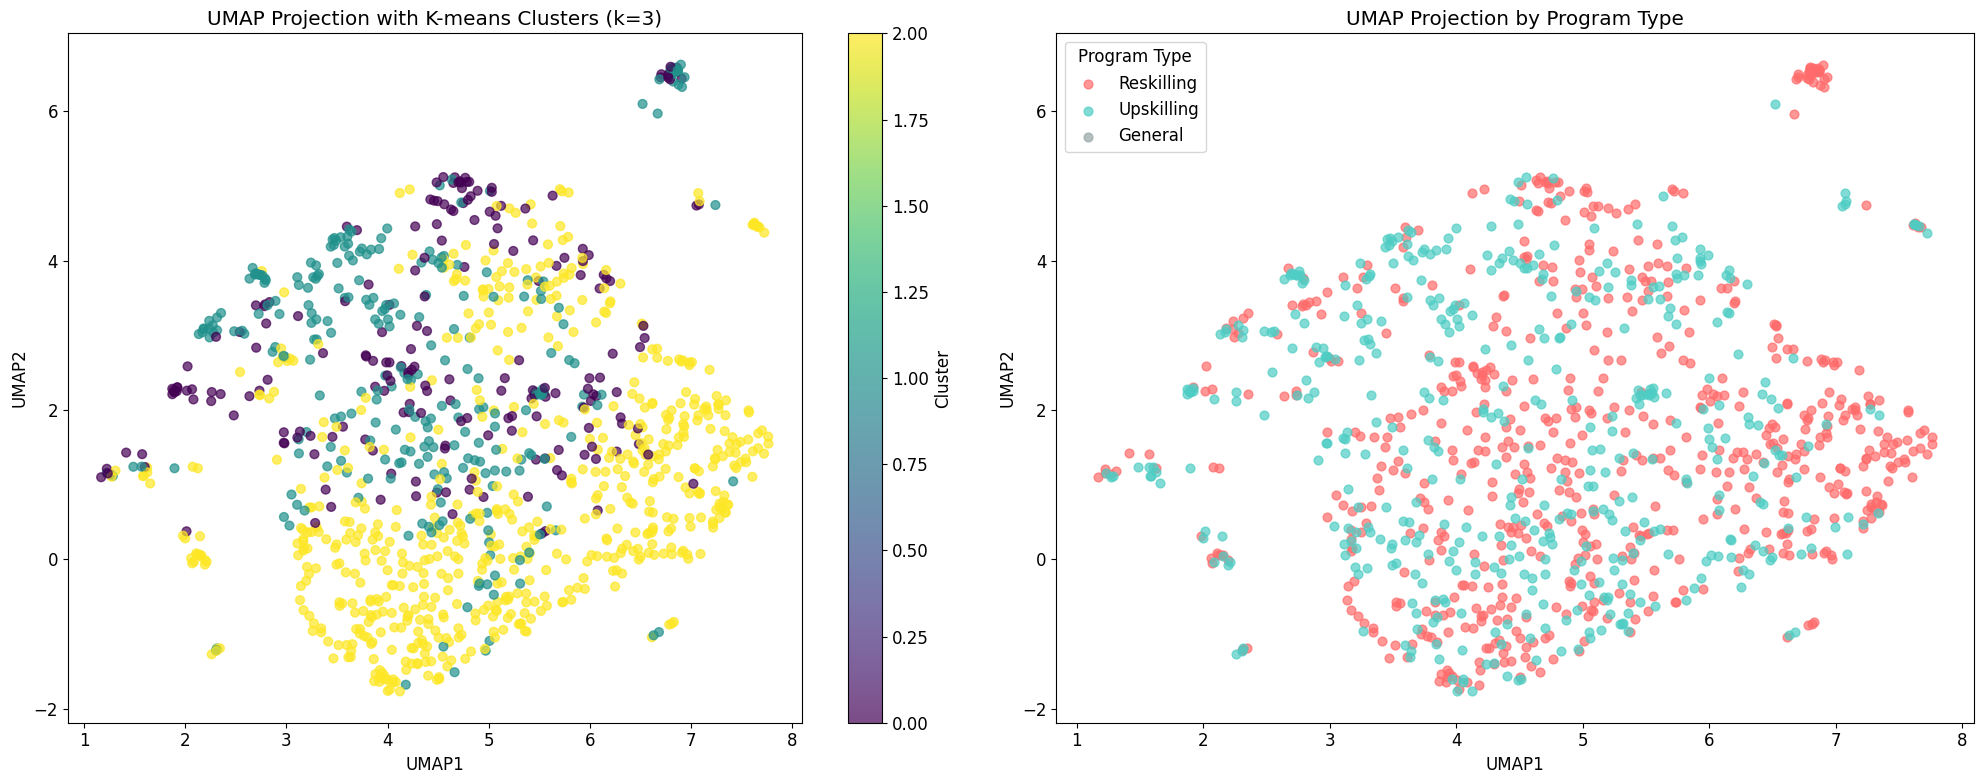

In [5]:
# Visualize clusters using UMAP
def visualize_clusters_with_umap(embedding, cluster_labels, n_clusters, program_types=None, figures_dir=figures_dir):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: K-means clusters
    scatter1 = ax1.scatter(embedding[:, 0], embedding[:, 1], 
                          c=cluster_labels, cmap='viridis',
                          alpha=0.7, s=40)
    ax1.set_title(f'UMAP Projection with K-means Clusters (k={n_clusters})')
    ax1.set_xlabel('UMAP1')
    ax1.set_ylabel('UMAP2')
    plt.colorbar(scatter1, ax=ax1, label='Cluster')
    
    # Plot 2: Program types (if provided)
    if program_types is not None:
        program_colors = {'Reskilling': '#FF6B6B', 'Upskilling': '#4ECDC4', 'General': '#95A5A6'}
        
        for program in program_colors:
            mask = program_types == program
            ax2.scatter(embedding[mask, 0], embedding[mask, 1], 
                       color=program_colors[program], label=program,
                       alpha=0.7, s=40)
        
        ax2.set_title('UMAP Projection by Program Type')
        ax2.set_xlabel('UMAP1')
        ax2.set_ylabel('UMAP2')
        ax2.legend(title='Program Type')
    
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/f'umap_clusters_{n_clusters}.png", dpi=300, bbox_inches='tight')
    plt.show()

# Visualize both clustering solutions
for n_clusters in [2, 3]:
    visualize_clusters_with_umap(
        umap_embedding, 
        clustering_results[n_clusters]['labels'], 
        n_clusters,
        program_types
    )

## 6. Analyze Cluster Composition by Program Type


Program distribution in 2 clusters:


<Figure size 1000x600 with 0 Axes>

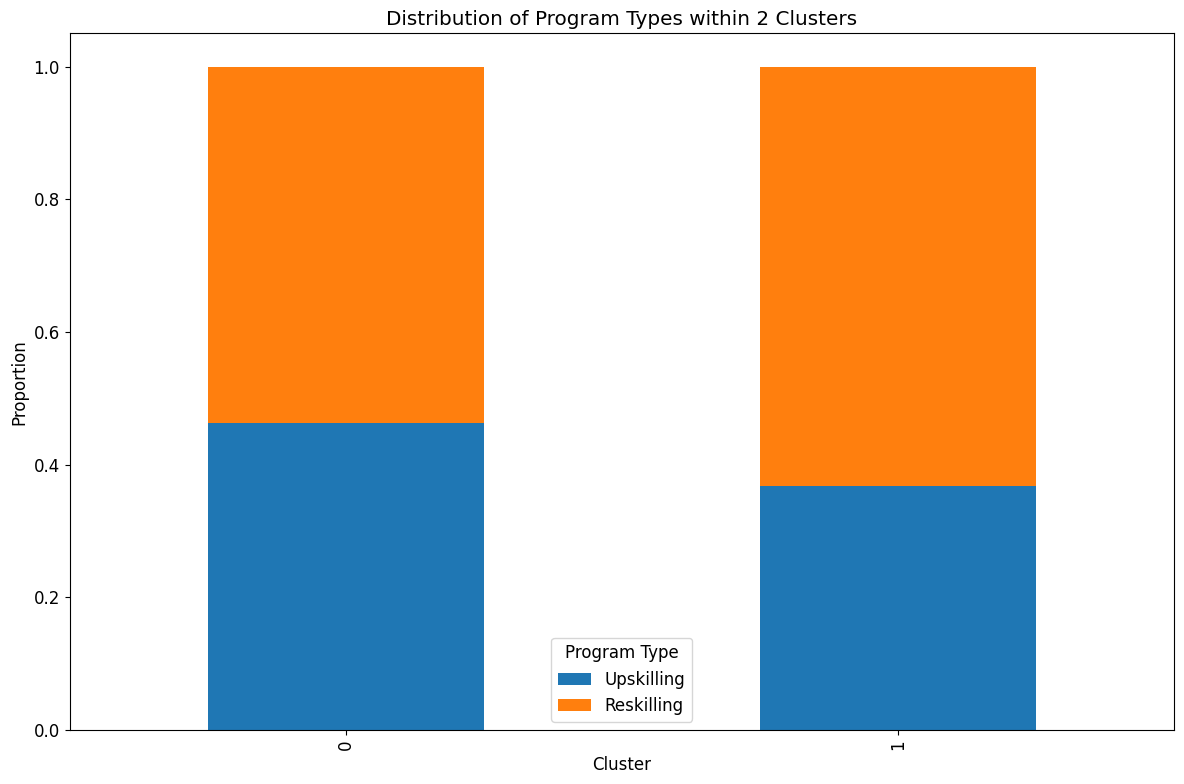

Program  Upskilling  Reskilling
Cluster                        
0          0.463519    0.536481
1          0.367223    0.632777

Program distribution in 3 clusters:


<Figure size 1000x600 with 0 Axes>

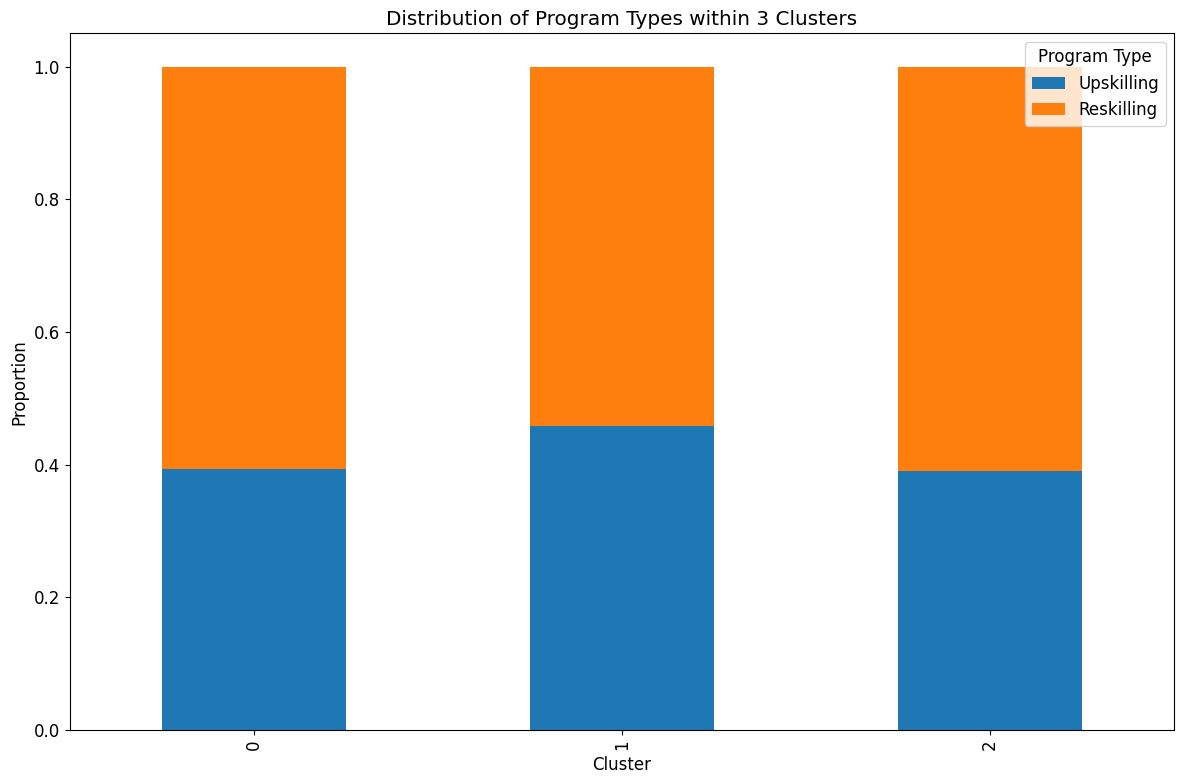

Program  Upskilling  Reskilling
Cluster                        
0          0.394089    0.605911
1          0.457565    0.542435
2          0.390169    0.609831


In [6]:
# Create a confusion matrix to compare clusters with program types
def analyze_cluster_program_distribution(cluster_labels, program_types, n_clusters, figures_dir=figures_dir):
    cluster_program_df = pd.DataFrame({
        'Cluster': cluster_labels,
        'Program': program_types.values
    })
    
    # Create confusion matrix
    confusion_matrix = pd.crosstab(
        cluster_program_df['Cluster'],
        cluster_program_df['Program'],
        normalize='index'
    )
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    confusion_matrix.plot(kind='bar', stacked=True)
    plt.title(f'Distribution of Program Types within {n_clusters} Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title='Program Type')
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/f'cluster_program_distribution_{n_clusters}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return confusion_matrix

# Analyze program distribution for both clustering solutions
for n_clusters in [2, 3]:
    print(f"\nProgram distribution in {n_clusters} clusters:")
    confusion_matrix = analyze_cluster_program_distribution(
        clustering_results[n_clusters]['labels'], 
        program_types,
        n_clusters
    )
    print(confusion_matrix)

## 7. Create Feature Importance Visualization


Top differentiating features for 2 clusters:


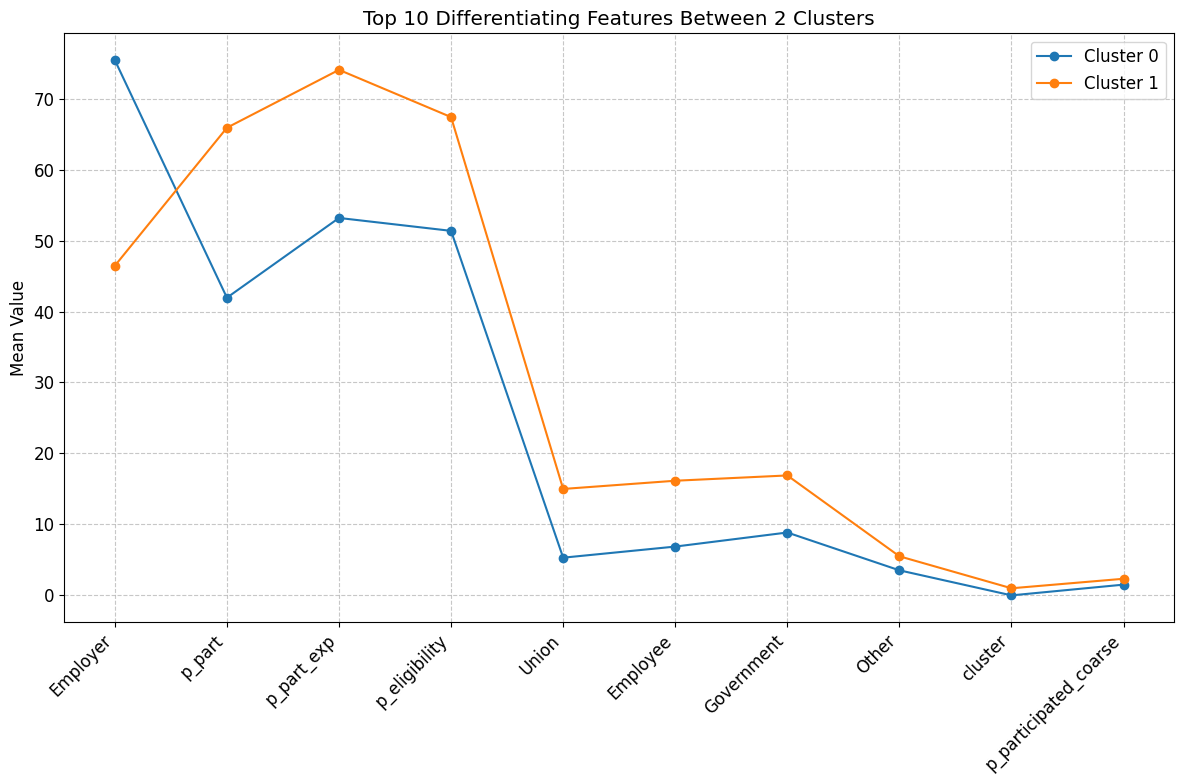


Top differentiating features for 3 clusters:


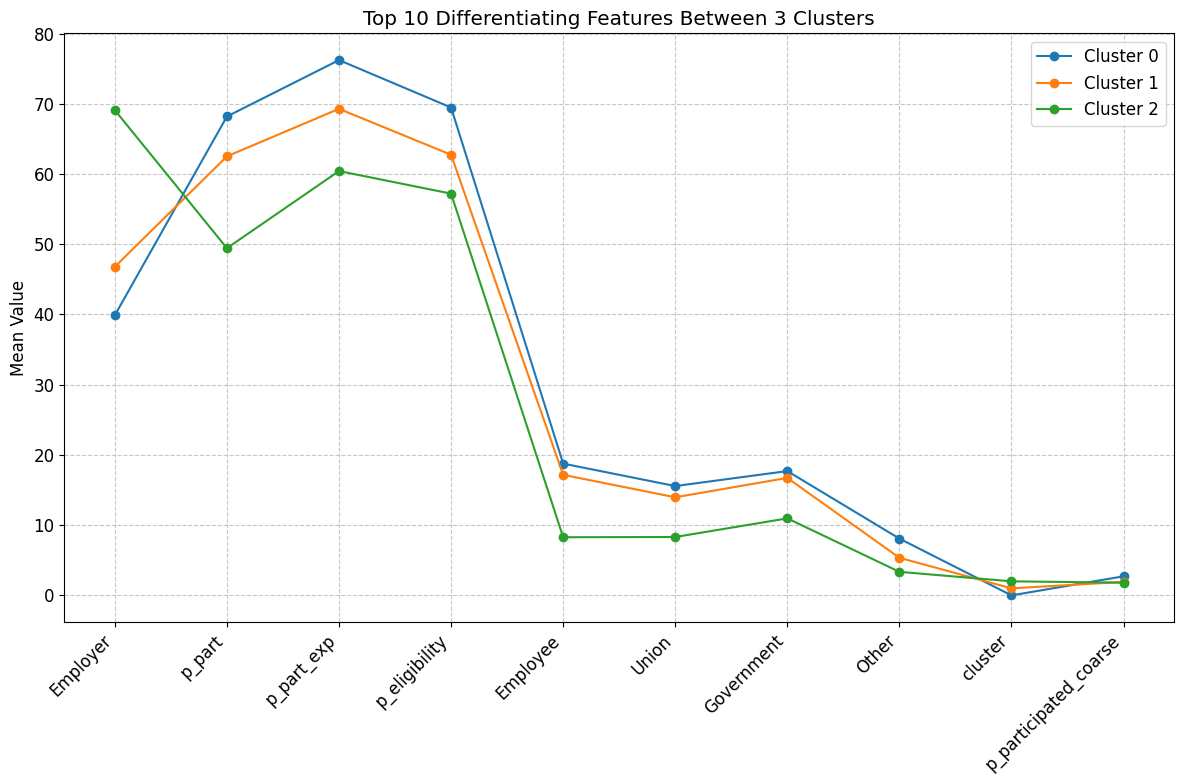

In [7]:
# Analyze which features are most important for defining each cluster
def analyze_feature_importance(data_dummies, cluster_labels, n_clusters, variable_labels, top_n=10, figures_dir=figures_dir):
    # Create a dataframe with the data and cluster labels
    df_with_clusters = data_dummies.copy()
    df_with_clusters['cluster'] = cluster_labels
    
    # Calculate feature means by cluster
    cluster_means = {}
    
    for cluster in range(n_clusters):
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster]
        cluster_means[cluster] = cluster_data.mean()
    
    # Convert to dataframe for easier handling
    means_df = pd.DataFrame(cluster_means)
    
    # Calculate the variance of means across clusters
    means_df['variance'] = means_df.var(axis=1)
    
    # Get top N features with highest variance
    top_features = means_df.nlargest(top_n, 'variance').index.tolist()
    
    # Create a feature comparison plot
    plt.figure(figsize=(12, 8))
    
    for cluster in range(n_clusters):
        values = [means_df.loc[feature, cluster] for feature in top_features]
        plt.plot(range(len(top_features)), values, marker='o', linestyle='-', label=f'Cluster {cluster}')
    
    # Replace feature names with labels if available
    feature_labels = []
    for feature in top_features:
        if feature in variable_labels and variable_labels[feature]:
            feature_labels.append(variable_labels[feature])
        else:
            feature_labels.append(feature)
    
    plt.xticks(range(len(top_features)), feature_labels, rotation=45, ha='right')
    plt.title(f'Top {top_n} Differentiating Features Between {n_clusters} Clusters')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/f'feature_importance_{n_clusters}_clusters.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return top_features, means_df

# Analyze feature importance for both clustering solutions
for n_clusters in [2, 3]:
    print(f"\nTop differentiating features for {n_clusters} clusters:")
    top_features, means_df = analyze_feature_importance(
        data_dummies, 
        clustering_results[n_clusters]['labels'],
        n_clusters,
        variable_labels
    )

## 8. Export Final Results

In [8]:
# Export final results
def export_results(data_dummies, clustering_results, program_types, stats_dir=stats_dir):
    for n_clusters in [2, 3]:
        # Create final dataset with cluster assignments
        result_df = data_dummies.copy()
        result_df['KMeans_Cluster'] = clustering_results[n_clusters]['labels']
        result_df['Program_Type'] = program_types.values
        
        # Export to CSV
        result_df.to_csv(f"{stats_dir}/f'cluster_results_{n_clusters}.csv", index=False)
        
        print(f"Results exported to cluster_results_{n_clusters}.csv")

# Export final results
export_results(data_dummies, clustering_results, program_types, stats_dir=stats_dir)

Results exported to cluster_results_2.csv
Results exported to cluster_results_3.csv


## 9. Evaluate Cluster Performance Against Program Types


Cluster distribution by program type:
col_0              0         1
program                       
Upskilling  0.471616  0.528384
Reskilling  0.374813  0.625187

Cluster vs. program type evaluation (k=2):
Accuracy: 0.59

Confusion matrix:
                   Cluster Upskilling  Cluster Reskilling
Actual Upskilling                   0                 458
Actual Reskilling                   0                 667

Classification report:
              precision    recall  f1-score   support

  Upskilling       0.00      0.00      0.00       458
  Reskilling       0.59      1.00      0.74       667

    accuracy                           0.59      1125
   macro avg       0.30      0.50      0.37      1125
weighted avg       0.35      0.59      0.44      1125



c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

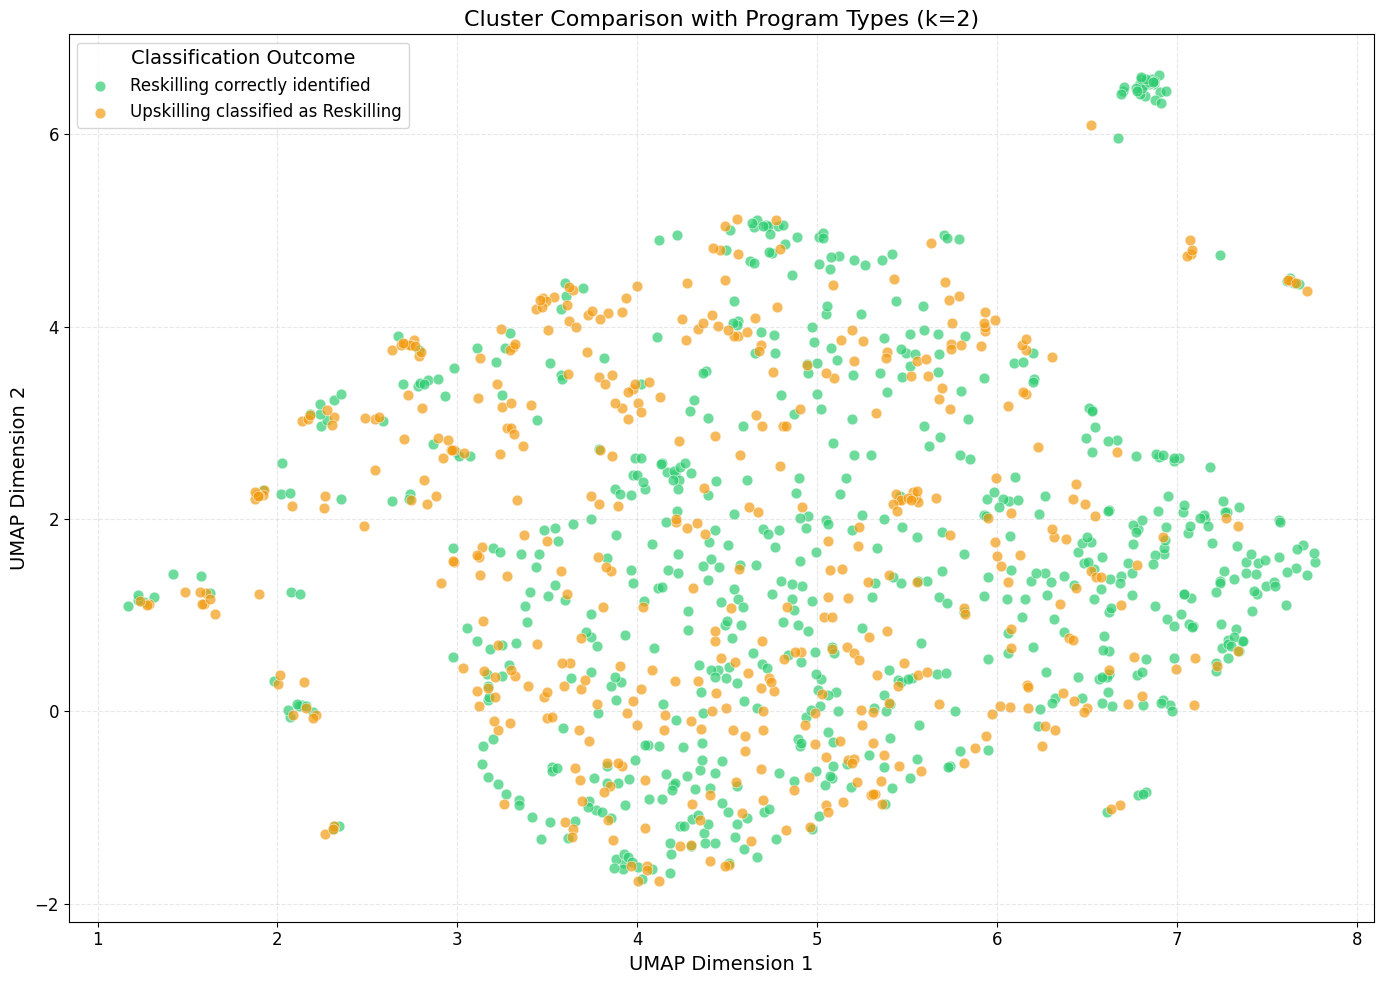

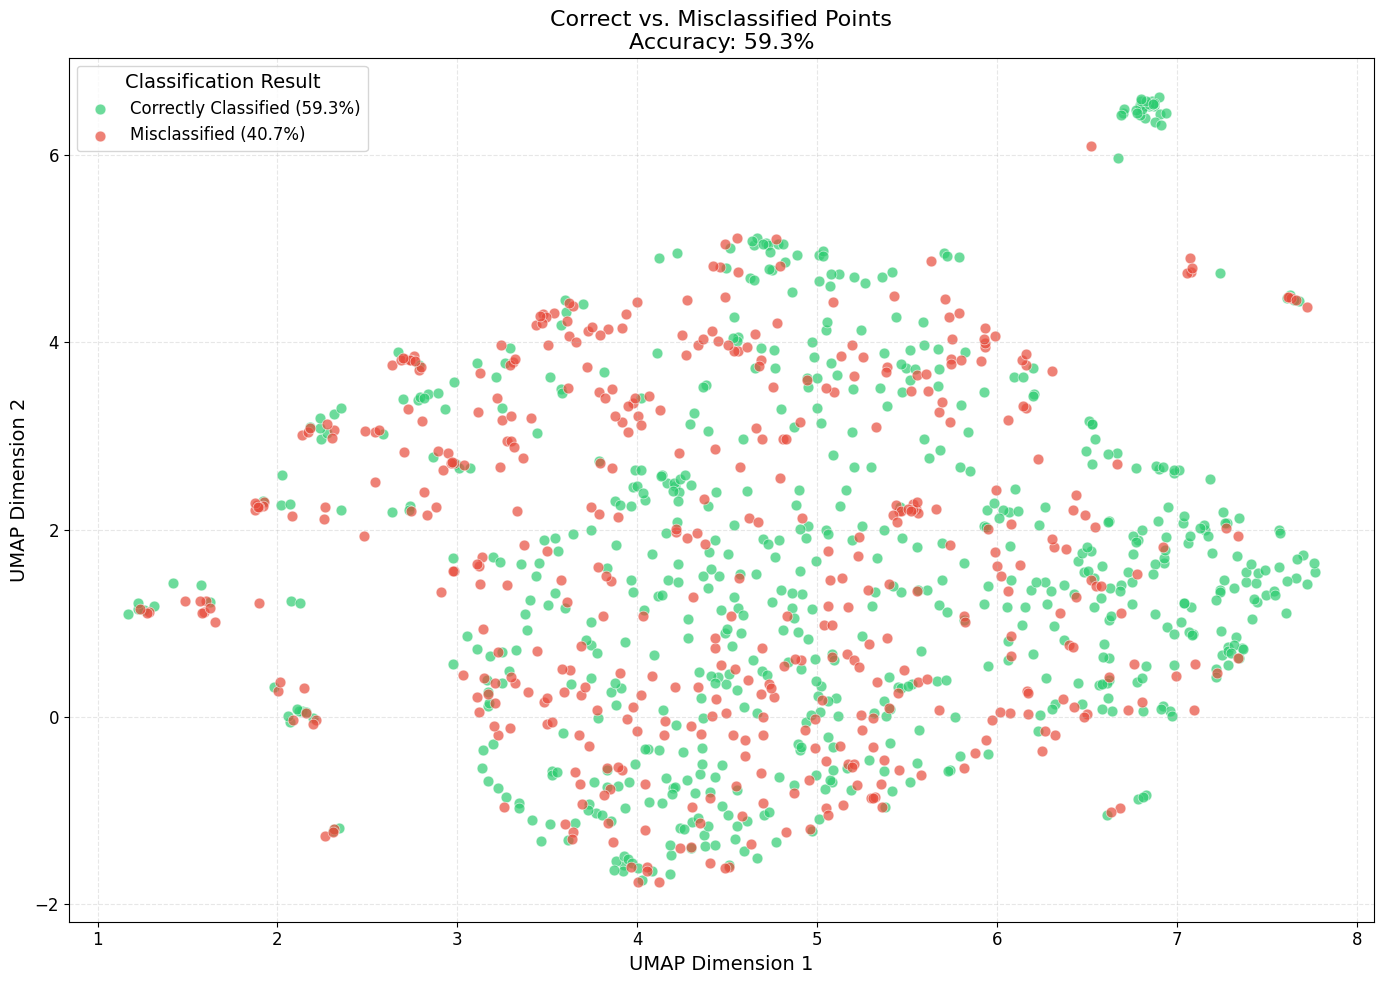


Cluster distribution by program type:
col_0              0         1         2
program                                 
Upskilling  0.174672  0.270742  0.554585
Reskilling  0.184408  0.220390  0.595202

Cluster vs. program type evaluation (k=3):
Adjusted Rand Index: 0.0057
(Values close to 1 indicate better alignment with program types)


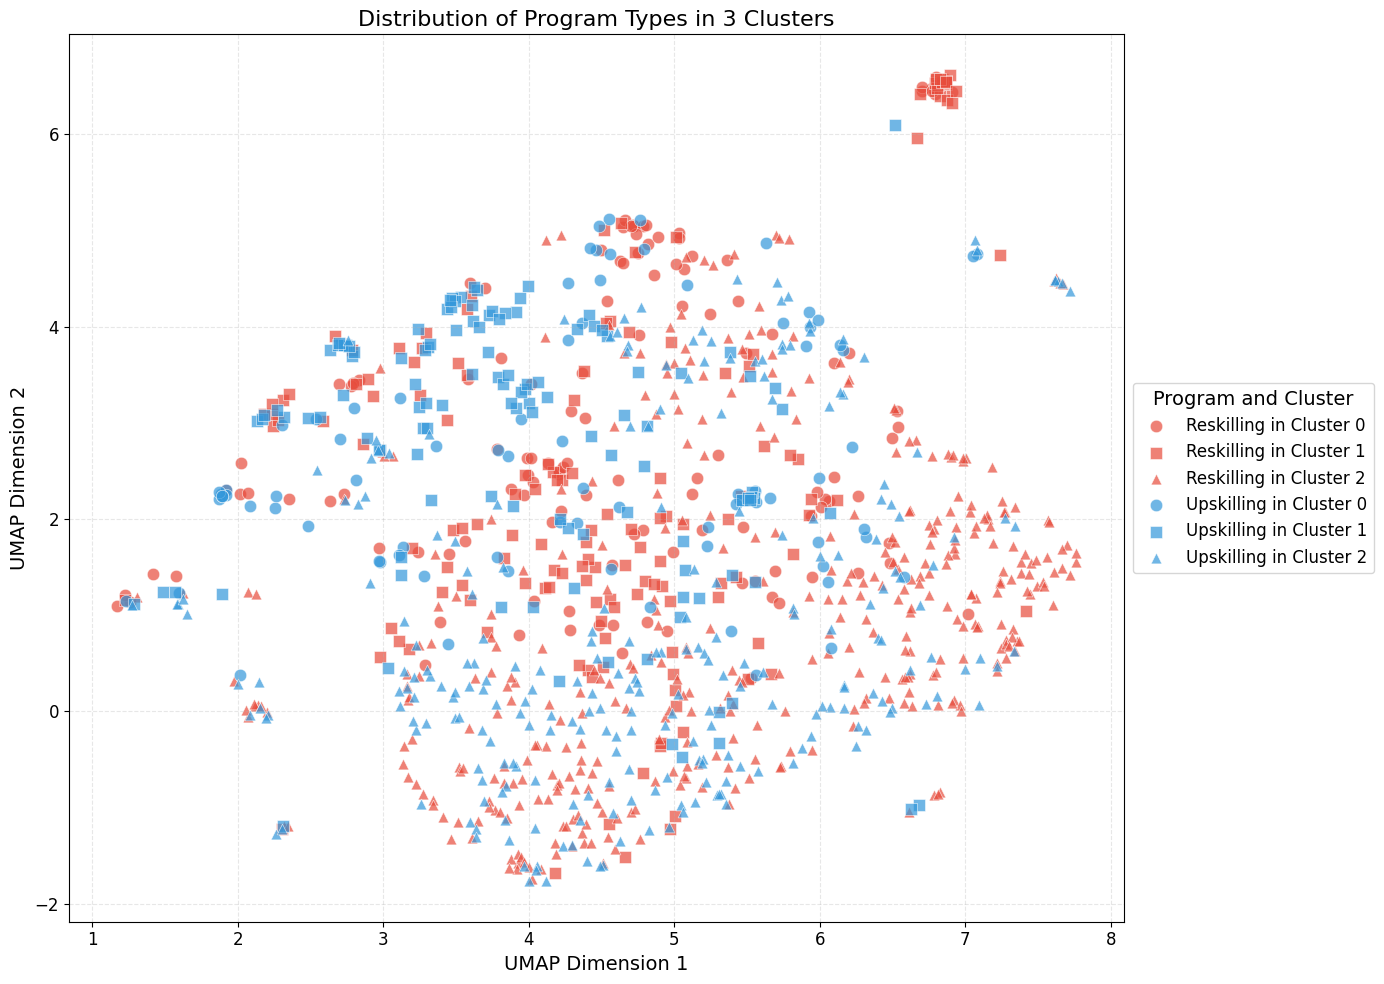


Cluster 0:
  Total programs: -203
  Reskilling: 123 (-60.6%)
  Upskilling: -326 (160.6%)
  Predominant type: Reskilling

Cluster 1:
  Total programs: -271
  Reskilling: 147 (-54.2%)
  Upskilling: -418 (154.2%)
  Predominant type: Reskilling

Cluster 2:
  Total programs: -651
  Reskilling: 397 (-61.0%)
  Upskilling: -1048 (161.0%)
  Predominant type: Reskilling


In [9]:
def plot_classification_results(relevant_embedding, binary_program, mapped_labels):

    # Define categories and colors
    categories = []
    colors = []

    correct_count = 0
    incorrect_count = 0

    for i in range(len(binary_program)):
        true_label = binary_program[i]
        pred_label = mapped_labels[i]

        if true_label == pred_label:
            categories.append('Correctly Classified')
            colors.append('#2ecc71')  # Green
            correct_count += 1
        else:
            categories.append('Misclassified')
            colors.append('#e74c3c')  # Red
            incorrect_count += 1

    total = correct_count + incorrect_count
    correct_pct = (correct_count / total) * 100
    incorrect_pct = (incorrect_count / total) * 100

    categories = np.array(categories)
    colors = np.array(colors)

    # Create the plot
    plt.figure(figsize=(14, 10))

    for category, color, pct in zip(
        ['Correctly Classified', 'Misclassified'], 
        ['#2ecc71', '#e74c3c'],
        [correct_pct, incorrect_pct]
    ):
        mask = categories == category
        if np.any(mask):
            plt.scatter(
                relevant_embedding[mask, 0], 
                relevant_embedding[mask, 1],
                c=color,
                label=f"{category} ({pct:.1f}%)",
                alpha=0.7,
                s=60,
                edgecolors='white',
                linewidth=0.5
            )

    plt.title(f'Correct vs. Misclassified Points\nAccuracy: {correct_pct:.1f}%', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)
    plt.legend(title='Classification Result', fontsize=12, title_fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


def evaluate_clusters_against_programs(cluster_labels, program_types, n_clusters, umap_embedding, figures_dir=figures_dir):
    from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, classification_report
    
    # Exclude the 'General' category for a clearer analysis between Reskilling and Upskilling
    mask_rs_us = program_types.isin(['Reskilling', 'Upskilling'])
    relevant_program_types = program_types[mask_rs_us]
    relevant_cluster_labels = cluster_labels[mask_rs_us]
    relevant_embedding = umap_embedding[mask_rs_us]
    
    # Create binary labels (Reskilling = 1, Upskilling = 0)
    binary_program = np.where(relevant_program_types == 'Reskilling', 1, 0)
    
    # Analyze the distribution of clusters by program type
    distribution = pd.crosstab(
        relevant_program_types, 
        relevant_cluster_labels,
        normalize='index'
    )
    
    print("\nCluster distribution by program type:")
    print(distribution)
    
    # Determine the best cluster-to-program-type mapping
    best_mapping = {}
    
    if n_clusters == 2:
        # In the case of 2 clusters, we simply check which cluster has a majority of Reskilling
        for cluster in range(n_clusters):
            cluster_mask = relevant_cluster_labels == cluster
            if cluster_mask.any():
                rs_ratio = np.mean(binary_program[cluster_mask])
                # If more than 50% are Reskilling, we assign the cluster to Reskilling
                best_mapping[cluster] = 1 if rs_ratio > 0.5 else 0
        
        # Create remapped labels
        mapped_labels = np.array([best_mapping.get(label, -1) for label in relevant_cluster_labels])
        
        # Compute metrics
        accuracy = accuracy_score(binary_program, mapped_labels)
        cm = confusion_matrix(binary_program, mapped_labels)
        
        # Create DataFrame for visualization
        cm_df = pd.DataFrame(
            cm, 
            index=['Actual Upskilling', 'Actual Reskilling'],
            columns=['Cluster Upskilling', 'Cluster Reskilling']
        )
        
        # Print results
        print(f"\nCluster vs. program type evaluation (k={n_clusters}):")
        print(f"Accuracy: {accuracy:.2f}")
        print("\nConfusion matrix:")
        print(cm_df)
        print("\nClassification report:")
        print(classification_report(binary_program, mapped_labels, 
                                    target_names=['Upskilling', 'Reskilling']))
        
        # Visualize results
        plt.figure(figsize=(14, 10))
        
        # Define categories for visualization
        categories = []
        colors = []
        
        for i in range(len(binary_program)):
            true_label = binary_program[i]
            pred_label = mapped_labels[i]
            
            if true_label == 1 and pred_label == 1:
                categories.append('Reskilling correctly identified')
                colors.append('#2ecc71')  # Green
            elif true_label == 0 and pred_label == 0:
                categories.append('Upskilling correctly identified')
                colors.append('#3498db')  # Blue
            elif true_label == 1 and pred_label == 0:
                categories.append('Reskilling classified as Upskilling')
                colors.append('#e74c3c')  # Red
            else:
                categories.append('Upskilling classified as Reskilling')
                colors.append('#f39c12')  # Orange
        
        categories = np.array(categories)
        colors = np.array(colors)
        
        # Create plot
        for category, color in zip(
            ['Reskilling correctly identified', 
             'Upskilling correctly identified',
             'Reskilling classified as Upskilling',
             'Upskilling classified as Reskilling'], 
            ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']):
            
            mask = categories == category
            if np.any(mask):
                plt.scatter(
                    relevant_embedding[mask, 0], 
                    relevant_embedding[mask, 1],
                    c=color,
                    label=category,
                    alpha=0.7,
                    s=60,
                    edgecolors='white',
                    linewidth=0.5
                )
        
        plt.title(f'Cluster Comparison with Program Types (k={n_clusters})', fontsize=16)
        plt.xlabel('UMAP Dimension 1', fontsize=14)
        plt.ylabel('UMAP Dimension 2', fontsize=14)
        plt.legend(title='Classification Outcome', fontsize=12, title_fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/f'cluster_program_comparison_{n_clusters}.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        plot_classification_results(relevant_embedding, binary_program, mapped_labels)
        
    else:
        # For 3+ clusters, we use Adjusted Rand Index and cross-tabulation
        ari = adjusted_rand_score(relevant_program_types, relevant_cluster_labels)
        
        print(f"\nCluster vs. program type evaluation (k={n_clusters}):")
        print(f"Adjusted Rand Index: {ari:.4f}")
        print("(Values close to 1 indicate better alignment with program types)")
        
        # Create plot
        plt.figure(figsize=(14, 10))
        
        # Define lighter color mapping
        program_colors = {
            'Reskilling': '#e74c3c',  # Red
            'Upskilling': '#3498db'   # Blue
        }
        
        # Use different markers for each cluster
        cluster_markers = {
            0: 'o',  # Circle
            1: 's',  # Square
            2: '^',  # Triangle
            3: 'D',  # Diamond
            4: 'v'   # Inverted triangle
        }
        
        # Sizes for better visualization
        cluster_sizes = {
            0: 80,
            1: 70,
            2: 60,
            3: 90,
            4: 80
        }
        
        # Plot by program type and cluster
        for program in program_colors:
            for cluster in range(n_clusters):
                mask = (relevant_program_types == program) & (relevant_cluster_labels == cluster)
                if np.any(mask):
                    plt.scatter(
                        relevant_embedding[mask, 0], 
                        relevant_embedding[mask, 1],
                        c=program_colors[program],
                        marker=cluster_markers[cluster],
                        s=cluster_sizes[cluster],
                        alpha=0.7,
                        label=f'{program} in Cluster {cluster}',
                        edgecolors='white',
                        linewidth=0.5
                    )
        
        plt.title(f'Distribution of Program Types in {n_clusters} Clusters', fontsize=16)
        plt.xlabel('UMAP Dimension 1', fontsize=14)
        plt.ylabel('UMAP Dimension 2', fontsize=14)
        plt.legend(title='Program and Cluster', fontsize=12, title_fontsize=14, 
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/f'program_distribution_{n_clusters}_clusters.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Cluster-wise analysis
        for cluster in range(n_clusters):
            mask = relevant_cluster_labels == cluster
            if mask.any():
                rs_count = np.sum(binary_program[mask])
                us_count = np.sum(~binary_program[mask])
                total = rs_count + us_count
                
                print(f"\nCluster {cluster}:")
                print(f"  Total programs: {total}")
                print(f"  Reskilling: {rs_count} ({rs_count/total*100:.1f}%)")
                print(f"  Upskilling: {us_count} ({us_count/total*100:.1f}%)")
                print(f"  Predominant type: {'Reskilling' if rs_count > us_count else 'Upskilling'}")

# Use the improved function
for n_clusters in [2, 3]:
    evaluate_clusters_against_programs(
        clustering_results[n_clusters]['labels'],
        program_types,
        n_clusters,
        umap_embedding
    )

## 10. Alternative Clustering Methods Comparison

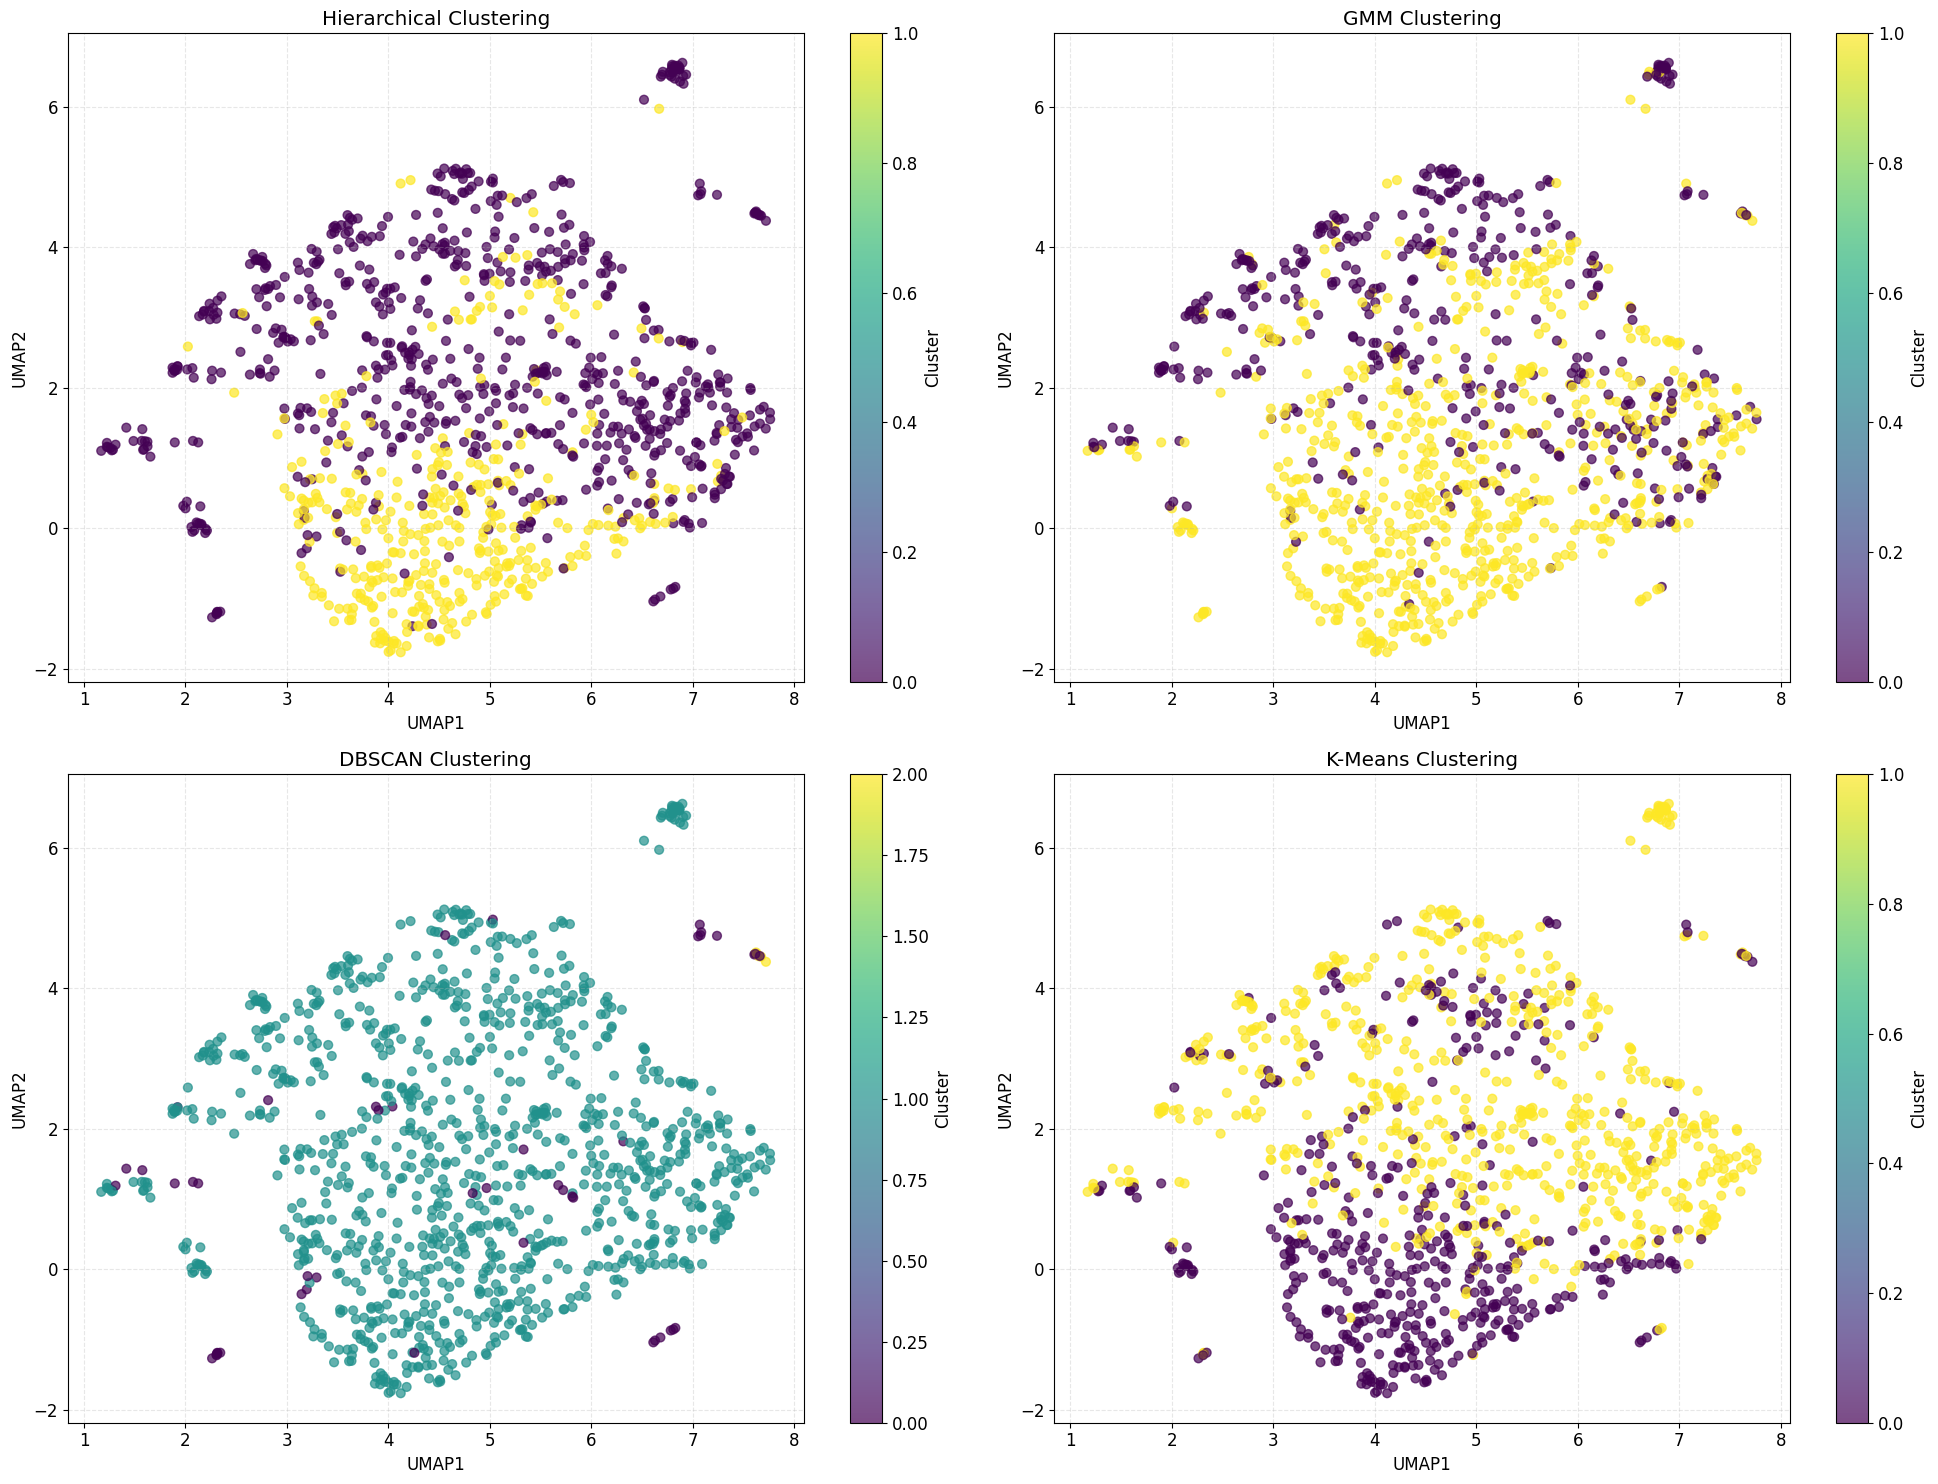


Clustering Methods Comparison:
--------------------------------------------------
Method          Accuracy   Silhouette   Time (s)  
--------------------------------------------------
Hierarchical    0.4258    0.0177     0.1302
GMM             0.5040    0.0363     0.8623
DBSCAN          0.5840    0.1575     0.1564
K-Means         0.5627    0.0360     0.0000

Best performing method: DBSCAN with accuracy: 0.5840


In [10]:
import kneed

# Compare K-Means with other clustering algorithms
def compare_clustering_methods(data_scaled, umap_embedding, program_types, figures_dir=figures_dir):
    from sklearn.cluster import AgglomerativeClustering, DBSCAN
    from sklearn.mixture import GaussianMixture
    import time
    
    # Dictionary to store results
    results = {}
    
    # Set number of clusters
    n_clusters = 2
    
    # 1. Hierarchical Clustering
    start_time = time.time()
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(data_scaled)
    hierarchical_time = time.time() - start_time
    
    # 2. Gaussian Mixture Model
    start_time = time.time()
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data_scaled)
    gmm_time = time.time() - start_time
    
    # 3. DBSCAN
    start_time = time.time()
    # Find a reasonable eps value based on nearest neighbors
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(data_scaled)
    distances, indices = nbrs.kneighbors(data_scaled)
    
    # Sort distances
    distances = np.sort(distances[:, 1])
    
    # Use the knee point as eps
    from kneed import KneeLocator
    knee_locator = KneeLocator(
        range(len(distances)), 
        distances, 
        S=1.0, 
        curve="convex", 
        direction="increasing"
    )
    eps = distances[knee_locator.knee] if knee_locator.knee else np.median(distances)
    
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(data_scaled)
    
    # Remap DBSCAN labels (which can be -1 for noise)
    # Treat noise points as a separate cluster
    dbscan_labels = dbscan_labels + 1  # Shift -1 to 0, 0 to 1, etc.
    dbscan_time = time.time() - start_time
    
    # Store results
    clustering_methods = {
        'Hierarchical': {
            'labels': hierarchical_labels,
            'time': hierarchical_time
        },
        'GMM': {
            'labels': gmm_labels,
            'time': gmm_time
        },
        'DBSCAN': {
            'labels': dbscan_labels,
            'time': dbscan_time
        }
    }
    
    # Add K-Means from previous analysis
    clustering_methods['K-Means'] = {
        'labels': clustering_results[n_clusters]['labels'],
        'time': 0  # We don't have timing for K-Means
    }
    
    # Visualize all methods together
    plt.figure(figsize=(20, 15))
    
    for i, (method_name, method_info) in enumerate(clustering_methods.items()):
        plt.subplot(2, 2, i+1)
        
        # Plot clusters
        scatter = plt.scatter(
            umap_embedding[:, 0],
            umap_embedding[:, 1],
            c=method_info['labels'],
            cmap='viridis',
            alpha=0.7,
            s=40
        )
        
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'{method_name} Clustering')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/clustering_methods_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate accuracy for all methods
    print("\nClustering Methods Comparison:")
    print("-" * 50)
    print(f"{'Method':<15} {'Accuracy':<10} {'Silhouette':<12} {'Time (s)':<10}")
    print("-" * 50)
    
    for method_name, method_info in clustering_methods.items():
        labels = method_info['labels']
        
        # Create binary labels for program types (Reskilling = 1, Others = 0)
        binary_program = np.where(program_types == 'Reskilling', 1, 0)
        
        # Check if we need to flip labels for better comparison
        cluster0_reskilling_count = np.sum((labels == 0) & (binary_program == 1))
        cluster0_upskilling_count = np.sum((labels == 0) & (binary_program == 0))
        
        if cluster0_upskilling_count > cluster0_reskilling_count:
            compare_labels = 1 - labels  # Flip 0->1 and 1->0
        else:
            compare_labels = labels
        
        # Calculate accuracy
        accuracy = np.mean(binary_program == compare_labels)
        
        # Calculate silhouette score if more than one cluster
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and len(unique_labels) < len(data_scaled):
            silhouette = silhouette_score(data_scaled, labels)
        else:
            silhouette = "N/A"
        
        print(f"{method_name:<15} {accuracy:.4f}    {silhouette if isinstance(silhouette, str) else silhouette:.4f}     {method_info['time']:.4f}")
    
    # Return best performing method based on accuracy
    accuracy_values = {}
    for method_name, method_info in clustering_methods.items():
        labels = method_info['labels']
        
        # Create binary labels for program types (Reskilling = 1, Others = 0)
        binary_program = np.where(program_types == 'Reskilling', 1, 0)
        
        # Check if we need to flip labels for better comparison
        cluster0_reskilling_count = np.sum((labels == 0) & (binary_program == 1))
        cluster0_upskilling_count = np.sum((labels == 0) & (binary_program == 0))
        
        if cluster0_upskilling_count > cluster0_reskilling_count:
            compare_labels = 1 - labels  # Flip 0->1 and 1->0
        else:
            compare_labels = labels
        
        # Calculate accuracy
        accuracy_values[method_name] = np.mean(binary_program == compare_labels)
    
    best_method = max(accuracy_values.items(), key=lambda x: x[1])
    
    print(f"\nBest performing method: {best_method[0]} with accuracy: {best_method[1]:.4f}")
    
    return clustering_methods

# Compare different clustering methods
clustering_methods = compare_clustering_methods(data_scaled, umap_embedding, program_types, figures_dir=figures_dir)

## 11. Statistical Comparison Between Program Types Across Clusters

This section focuses on generating a quantitative comparison between Upskilling and Reskilling programs across different clusters. We'll analyze key variables to understand:

1. How program characteristics differ between clusters
2. How Upskilling and Reskilling programs differ within each cluster
3. Which variables contribute most significantly to these differences

The analysis generates a structured CSV file containing detailed statistics (means, standard deviations, p-values) for each variable, providing insights into the distinctive features of each program type within each cluster. This approach allows us to move beyond descriptive clustering to statistically validated comparisons that can inform program implementation strategies.

In [11]:
## 11. Statistical Comparison Between Program Types Across Clusters

# Import variable definitions
from variable_definitions import (
    label_mapping, program_variables, outcomes_to_exclude, add_unique_keys
)

def generate_comprehensive_statistics(data_dummies, cluster_labels, program_types, variable_labels, output_dir = "../Output/Results_Clusters" figures_dir=None, stats_dir=None, reports_dir=None):
    """
    Generate comprehensive statistics comparing variables
    
    Args:
        data_dummies: Preprocessed dataset with dummy variables
        cluster_labels: Array of cluster assignments
        program_types: Original program types
        variable_labels: Dictionary mapping variable names to readable labels
        output_dir: Base directory for all outputs
        figures_dir: Directory for visualization outputs
        stats_dir: Directory for statistical results
        reports_dir: Directory for generated reports
    """
    
    import os
    import scipy.stats as stats
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    
    # Set default directories if not provided
    if figures_dir is None:
        figures_dir = os.path.join(output_dir, "Figures")
    if stats_dir is None:
        stats_dir = os.path.join(output_dir, "Statistics")
    if reports_dir is None:
        reports_dir = os.path.join(output_dir, "Reports")
        
    # Create directories if they don't exist
    for directory in [output_dir, figures_dir, stats_dir, reports_dir]:
        os.makedirs(directory, exist_ok=True)
# Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Set default directories if not provided
    if figures_dir is None:
        figures_dir = os.path.join(output_dir, "Figures")
    if stats_dir is None:
        stats_dir = os.path.join(output_dir, "Statistics")
    if reports_dir is None:
        reports_dir = os.path.join(output_dir, "Reports")
        
    # Create directories if they don't exist
    for directory in [figures_dir, stats_dir, reports_dir]:
        os.makedirs(directory, exist_ok=True)

    
    # Create a DataFrame with data, cluster labels, and program types
    analysis_df = data_dummies.copy()
    analysis_df['cluster'] = cluster_labels
    analysis_df['program_type'] = program_types.values
    
    # Filter to focus on Upskilling and Reskilling programs (excluding General)
    analysis_df = analysis_df[analysis_df['program_type'].isin(['Upskilling', 'Reskilling'])]
    
    # Create binary indicator for program type (1 = Reskilling, 0 = Upskilling)
    analysis_df['is_reskilling'] = np.where(analysis_df['program_type'] == 'Reskilling', 1, 0)
    
    # Get unique clusters
    unique_clusters = sorted(analysis_df['cluster'].unique())
    n_clusters = len(unique_clusters)
    
    # Initialize dictionaries for results
    results = {
        'cluster_comparison': pd.DataFrame(),
        'program_comparison_overall': pd.DataFrame(),
        'program_comparison_by_cluster': {cluster: pd.DataFrame() for cluster in unique_clusters},
        'variable_importance': pd.DataFrame()
    }
    
    # Get variable categories for organization
    var_categories = {
        'funding': [col for col in analysis_df.columns if 'fund' in col.lower()],
        'program_structure': [col for col in analysis_df.columns if any(x in col.lower() for x in 
                             ['length', 'duration', 'hours', 'part_', 'eligibility'])],
        'program_design': [col for col in analysis_df.columns if any(x in col.lower() for x in 
                          ['design', 'pilot', 'delivery', 'advocacy', 'responsibility'])],
        'incentives': [col for col in analysis_df.columns if any(x in col.lower() for x in 
                      ['incentive', 'inc_', 'mot_'])],
        'targeting': [col for col in analysis_df.columns if any(x in col.lower() for x in 
                     ['target', 'criteria'])],
        'kpis': [col for col in analysis_df.columns if any(x in col.lower() for x in 
                ['kpi', 'track', 'review'])]
    }
    
    # Add remaining variables to 'other' category
    used_vars = [var for cat_vars in var_categories.values() for var in cat_vars]
    var_categories['other'] = [col for col in analysis_df.columns 
                              if col not in used_vars 
                              and col not in ['cluster', 'program_type', 'is_reskilling']
                              and not col.startswith('program_')]
    
    # Ensure all variables have labels
    for category, vars_list in var_categories.items():
        for var in vars_list:
            if var not in variable_labels or variable_labels.get(var) is None:
                print(f"Missing label for variable: {var}, setting to variable name")
                variable_labels[var] = var
    
    # 1. Compare variables between clusters
    print("\nComparing variables between clusters...")
    cluster_stats = []
    
    for category, variables in var_categories.items():
        for var in variables:
            if var in analysis_df.columns:
                try:
                    # Descriptive statistics by cluster
                    means = [analysis_df[analysis_df['cluster'] == cluster][var].mean() 
                            for cluster in unique_clusters]
                    stds = [analysis_df[analysis_df['cluster'] == cluster][var].std() 
                           for cluster in unique_clusters]
                    
                    # Compute overall Z-scores for the variable
                    overall_mean = analysis_df[var].mean()
                    overall_std = analysis_df[var].std()
                    
                    # Avoid division by zero
                    if overall_std == 0:
                        z_scores = [0 for _ in means]
                    else:
                        z_scores = [(mean - overall_mean) / overall_std for mean in means]
                    
                    # Statistical test for differences between clusters
                    if n_clusters == 2:
                        # For 2 clusters, use independent t-test
                        cluster0_data = analysis_df[analysis_df['cluster'] == unique_clusters[0]][var]
                        cluster1_data = analysis_df[analysis_df['cluster'] == unique_clusters[1]][var]
                        
                        t_stat, p_value = stats.ttest_ind(
                            cluster0_data, 
                            cluster1_data,
                            equal_var=False  # Use Welch's t-test for unequal variances
                        )
                        test_name = "t-test"
                        test_stat = t_stat
                    else:
                        # For 3+ clusters, use ANOVA
                        groups = [analysis_df[analysis_df['cluster'] == cluster][var] 
                                 for cluster in unique_clusters]
                        f_stat, p_value = stats.f_oneway(*groups)
                        test_name = "ANOVA"
                        test_stat = f_stat
                    
                    # Determine significance level
                    if p_value < 0.001:
                        sig_level = "***"
                    elif p_value < 0.01:
                        sig_level = "**"
                    elif p_value < 0.05:
                        sig_level = "*"
                    else:
                        sig_level = ""
                    
                    # Add row to results
                    row = {
                        'category': category,
                        'variable': var,
                        'variable_label': variable_labels.get(var, var),
                        'test': test_name,
                        'test_statistic': test_stat,
                        'p_value': p_value,
                        'significance': sig_level
                    }
                    
                    # Add means, stds, and z-scores for each cluster
                    for i, cluster in enumerate(unique_clusters):
                        row[f'mean_cluster{cluster}'] = means[i]
                        row[f'std_cluster{cluster}'] = stds[i]
                        row[f'z_score_cluster{cluster}'] = z_scores[i]
                    
                    cluster_stats.append(row)
                except Exception as e:
                    print(f"Error processing variable {var} for cluster comparison: {e}")
    
    # Create DataFrame from results
    cluster_comparison_df = pd.DataFrame(cluster_stats)
    
    # Sort by p-value
    if not cluster_comparison_df.empty:
        cluster_comparison_df = cluster_comparison_df.sort_values('p_value')
        results['cluster_comparison'] = cluster_comparison_df
    
    # 2. Compare program types (Upskilling vs Reskilling) overall
    print("\nComparing program types overall...")
    program_stats = []
    
    for category, variables in var_categories.items():
        for var in variables:
            if var in analysis_df.columns:
                try:
                    # Descriptive statistics by program type
                    upskilling_data = analysis_df[analysis_df['program_type'] == 'Upskilling'][var]
                    reskilling_data = analysis_df[analysis_df['program_type'] == 'Reskilling'][var]
                    
                    up_mean = upskilling_data.mean()
                    up_std = upskilling_data.std()
                    re_mean = reskilling_data.mean()
                    re_std = reskilling_data.std()
                    
                    # Compute effect size (Cohen's d)
                    pooled_std = np.sqrt(((len(upskilling_data) - 1) * up_std**2 + 
                                         (len(reskilling_data) - 1) * re_std**2) / 
                                        (len(upskilling_data) + len(reskilling_data) - 2))
                    
                    if pooled_std == 0:  # Avoid division by zero
                        cohens_d = 0
                    else:
                        cohens_d = (re_mean - up_mean) / pooled_std
                    
                    # T-test for difference between program types
                    t_stat, p_value = stats.ttest_ind(
                        upskilling_data, 
                        reskilling_data,
                        equal_var=False  # Use Welch's t-test for unequal variances
                    )
                    
                    # Determine significance level
                    if p_value < 0.001:
                        sig_level = "***"
                    elif p_value < 0.01:
                        sig_level = "**"
                    elif p_value < 0.05:
                        sig_level = "*"
                    else:
                        sig_level = ""
                    
                    # Add row to results
                    row = {
                        'category': category,
                        'variable': var,
                        'variable_label': variable_labels.get(var, var),
                        'upskilling_mean': up_mean,
                        'upskilling_std': up_std,
                        'reskilling_mean': re_mean,
                        'reskilling_std': re_std,
                        'cohens_d': cohens_d,
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'significance': sig_level
                    }
                    
                    program_stats.append(row)
                except Exception as e:
                    print(f"Error processing variable {var} for program comparison: {e}")
    
    # Create DataFrame from results
    program_comparison_df = pd.DataFrame(program_stats)
    
    # Sort by p-value
    if not program_comparison_df.empty:
        program_comparison_df = program_comparison_df.sort_values('p_value')
        results['program_comparison_overall'] = program_comparison_df
    
    # 3. Compare program types within each cluster
    print("\nComparing program types within each cluster...")
    
    for cluster in unique_clusters:
        cluster_data = analysis_df[analysis_df['cluster'] == cluster]
        
        # Skip if a cluster doesn't have both program types
        program_types_in_cluster = cluster_data['program_type'].unique()
        if len(program_types_in_cluster) < 2:
            print(f"Cluster {cluster} only has one program type: {program_types_in_cluster[0]}")
            continue
        
        cluster_program_stats = []
        
        for category, variables in var_categories.items():
            for var in variables:
                if var in cluster_data.columns:
                    try:
                        # Descriptive statistics by program type within cluster
                        cluster_upskilling = cluster_data[cluster_data['program_type'] == 'Upskilling'][var]
                        cluster_reskilling = cluster_data[cluster_data['program_type'] == 'Reskilling'][var]
                        
                        if len(cluster_upskilling) == 0 or len(cluster_reskilling) == 0:
                            continue  # Skip if one group is empty
                        
                        up_mean = cluster_upskilling.mean()
                        up_std = cluster_upskilling.std()
                        re_mean = cluster_reskilling.mean()
                        re_std = cluster_reskilling.std()
                        
                        # Compute effect size (Cohen's d)
                        pooled_std = np.sqrt(((len(cluster_upskilling) - 1) * up_std**2 + 
                                             (len(cluster_reskilling) - 1) * re_std**2) / 
                                            (len(cluster_upskilling) + len(cluster_reskilling) - 2))
                        
                        if pooled_std == 0:  # Avoid division by zero
                            cohens_d = 0
                        else:
                            cohens_d = (re_mean - up_mean) / pooled_std
                        
                        # T-test for difference between program types within cluster
                        t_stat, p_value = stats.ttest_ind(
                            cluster_upskilling, 
                            cluster_reskilling,
                            equal_var=False  # Use Welch's t-test for unequal variances
                        )
                        
                        # Determine significance level
                        if p_value < 0.001:
                            sig_level = "***"
                        elif p_value < 0.01:
                            sig_level = "**"
                        elif p_value < 0.05:
                            sig_level = "*"
                        else:
                            sig_level = ""
                        
                        # Add row to results
                        row = {
                            'category': category,
                            'variable': var,
                            'variable_label': variable_labels.get(var, var),
                            'upskilling_mean': up_mean,
                            'upskilling_std': up_std,
                            'reskilling_mean': re_mean,
                            'reskilling_std': re_std,
                            'cohens_d': cohens_d,
                            't_statistic': t_stat,
                            'p_value': p_value,
                            'significance': sig_level
                        }
                        
                        cluster_program_stats.append(row)
                    except Exception as e:
                        print(f"Error processing variable {var} for cluster {cluster}: {e}")
        
        # Create DataFrame from results
        cluster_program_df = pd.DataFrame(cluster_program_stats)
        
        # Sort by p-value
        if not cluster_program_df.empty:
            cluster_program_df = cluster_program_df.sort_values('p_value')
            results['program_comparison_by_cluster'][cluster] = cluster_program_df
    
    # 4. Calculate variable importance for differentiating program types
    print("\nCalculating variable importance...")
    
    # Train a simple model to get feature importance
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    
    # Select features (excluding cluster, program_type, and is_reskilling)
    feature_cols = [col for col in analysis_df.columns 
                   if col not in ['cluster', 'program_type', 'is_reskilling']
                   and not col.startswith('program_')]
    
    X = analysis_df[feature_cols]
    y = analysis_df['is_reskilling']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    
    # Get feature importance
    importances = rf.feature_importances_
    
    # Create DataFrame with feature importance
    importance_df = pd.DataFrame({
        'variable': feature_cols,
        'importance': importances
    })
    
    # Add variable labels
    importance_df['variable_label'] = importance_df['variable'].map(
        lambda x: variable_labels.get(x, x)
    )
    
    # Add variable category
    def get_category(var):
        for cat, vars_list in var_categories.items():
            if var in vars_list:
                return cat
        return 'other'
    
    importance_df['category'] = importance_df['variable'].apply(get_category)
    
    # Sort by importance
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    results['variable_importance'] = importance_df
    
    # 5. Save results to files
    print("\nSaving results to files...")
    
    # Cluster comparison
    if not results['cluster_comparison'].empty:
        results['cluster_comparison'].to_csv(f"{stats_dir}/cluster_comparison.csv", index=False)
        
        # Create summary version with top 20 most significant variables
        top_clusters = results['cluster_comparison'].head(20)
        top_clusters.to_csv(f"{stats_dir}/top20_cluster_differences.csv", index=False)
    
    # Program comparison overall
    if not results['program_comparison_overall'].empty:
        results['program_comparison_overall'].to_csv(f"{stats_dir}/program_comparison_overall.csv", index=False)
        
        # Create summary version with top 20 most significant variables
        top_programs = results['program_comparison_overall'].head(20)
        top_programs.to_csv(f"{stats_dir}/top20_program_differences.csv", index=False)
    
    # Program comparison by cluster
    for cluster, df in results['program_comparison_by_cluster'].items():
        if not df.empty:
            df.to_csv(f"{stats_dir}/program_comparison_cluster{cluster}.csv", index=False)
            
            # Create summary version with top 10 most significant variables
            top_cluster_programs = df.head(10)
            top_cluster_programs.to_csv(f"{stats_dir}/top10_program_differences_cluster{cluster}.csv", index=False)
    
    # Variable importance
    results['variable_importance'].to_csv(f"{stats_dir}/variable_importance.csv", index=False)
    
    # 6. Generate summary report
    print("\nGenerating summary report...")
    
    with open(f"{reports_dir}/summary_report.md", "w") as f:
        f.write("# Comprehensive Statistical Analysis\n\n")
        
        # Summary of dataset
        f.write("## Dataset Summary\n\n")
        f.write(f"- Total programs analyzed: {len(analysis_df)}\n")
        f.write(f"- Number of clusters: {n_clusters}\n")
        
        # Program distribution
        f.write("\n### Program Type Distribution\n\n")
        program_dist = analysis_df['program_type'].value_counts()
        f.write(f"- Upskilling programs: {program_dist.get('Upskilling', 0)}\n")
        f.write(f"- Reskilling programs: {program_dist.get('Reskilling', 0)}\n")
        
        # Program distribution by cluster
        f.write("\n### Program Type Distribution by Cluster\n\n")
        f.write("| Cluster | Upskilling | Reskilling | Total |\n")
        f.write("|---------|------------|------------|-------|\n")
        
        for cluster in unique_clusters:
            cluster_data = analysis_df[analysis_df['cluster'] == cluster]
            up_count = len(cluster_data[cluster_data['program_type'] == 'Upskilling'])
            re_count = len(cluster_data[cluster_data['program_type'] == 'Reskilling'])
            total = up_count + re_count
            f.write(f"| {cluster} | {up_count} | {re_count} | {total} |\n")
        
        # Top differentiating variables between clusters
        if not results['cluster_comparison'].empty:
            f.write("\n## Top 10 Variables Differentiating Clusters\n\n")
            f.write("| Variable | ")
            
            for cluster in unique_clusters:
                f.write(f"Cluster {cluster} | ")
            
            f.write("p-value | Significance |\n")
            f.write("|---------|")
            
            for _ in unique_clusters:
                f.write("---------|")
            
            f.write("---------|-------------|\n")
            
            for _, row in results['cluster_comparison'].head(10).iterrows():
                var_label = row['variable_label'] if row['variable_label'] is not None else row['variable']
                f.write(f"| {var_label} | ")
                
                for cluster in unique_clusters:
                    mean = row[f'mean_cluster{cluster}']
                    f.write(f"{mean:.2f} | ")
                
                f.write(f"{row['p_value']:.4f} | {row['significance']} |\n")
        
        # Top differentiating variables between program types
        if not results['program_comparison_overall'].empty:
            f.write("\n## Top 10 Variables Differentiating Program Types\n\n")
            f.write("| Variable | Upskilling | Reskilling | Cohen's d | p-value | Significance |\n")
            f.write("|---------|-----------|-----------|-----------|---------|-------------|\n")
            
            for _, row in results['program_comparison_overall'].head(10).iterrows():
                var_label = row['variable_label'] if row['variable_label'] is not None else row['variable']
                up_mean = row['upskilling_mean']
                re_mean = row['reskilling_mean']
                cohens_d = row['cohens_d']
                p_value = row['p_value']
                sig = row['significance']
                
                f.write(f"| {var_label} | {up_mean:.2f} | {re_mean:.2f} | {cohens_d:.2f} | {p_value:.4f} | {sig} |\n")
        
        # Top variables for program differentiation within each cluster
        f.write("\n## Program Type Differentiation Within Clusters\n\n")
        
        for cluster in unique_clusters:
            if cluster in results['program_comparison_by_cluster'] and not results['program_comparison_by_cluster'][cluster].empty:
                f.write(f"\n### Cluster {cluster}\n\n")
                f.write("| Variable | Upskilling | Reskilling | Cohen's d | p-value | Significance |\n")
                f.write("|---------|-----------|-----------|-----------|---------|-------------|\n")
                
                for _, row in results['program_comparison_by_cluster'][cluster].head(5).iterrows():
                    var_label = row['variable_label'] if row['variable_label'] is not None else row['variable']
                    up_mean = row['upskilling_mean']
                    re_mean = row['reskilling_mean']
                    cohens_d = row['cohens_d']
                    p_value = row['p_value']
                    sig = row['significance']
                    
                    f.write(f"| {var_label} | {up_mean:.2f} | {re_mean:.2f} | {cohens_d:.2f} | {p_value:.4f} | {sig} |\n")
        
        # Variable importance
        f.write("\n## Top 10 Most Important Variables for Program Type Prediction\n\n")
        f.write("| Variable | Importance |\n")
        f.write("|---------|------------|\n")
        
        for _, row in results['variable_importance'].head(10).iterrows():
            var_label = row['variable_label'] if row['variable_label'] is not None else row['variable']
            importance = row['importance']
            
            f.write(f"| {var_label} | {importance:.4f} |\n")
    
    # 7. Generate visualizations
    print("\nGenerating visualizations...")
    
    # Set up plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 7.1 Top variables differentiating clusters
    if not results['cluster_comparison'].empty:
        top_vars = results['cluster_comparison'].head(15)
        
        plt.figure(figsize=(12, 10))
        
        # Prepare data for plotting
        variables = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 30 
                    else label_mapping.get(var, var)[:27] + '...' 
                    for var in top_vars['variable']]
        
        cluster_data = []
        for cluster in unique_clusters:
            cluster_data.append(top_vars[f'z_score_cluster{cluster}'].values)
        
        # Set up x positions
        x = np.arange(len(variables))
        width = 0.8 / n_clusters
        
        # Create bars
        for i, cluster in enumerate(unique_clusters):
            plt.bar(x + i * width - width * n_clusters / 2 + width / 2, 
                   cluster_data[i], 
                   width, 
                   label=f'Cluster {cluster}')
        
        # Add details
        plt.xlabel('Variables')
        plt.ylabel('Z-Score')
        plt.title('Top Variables Differentiating Clusters (Standardized)')
        plt.xticks(x, variables, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/top_cluster_variables.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # Create a heatmap version
        plt.figure(figsize=(14, 10))
        
        # Reshape data for heatmap
        heatmap_data = pd.DataFrame({
            'Variable': variables
        })
        
        for cluster in unique_clusters:
            heatmap_data[f'Cluster {cluster}'] = top_vars[f'z_score_cluster{cluster}'].values
        
        # Set the variable as index
        heatmap_data = heatmap_data.set_index('Variable')
        
        # Create heatmap
        sns.heatmap(heatmap_data, cmap='coolwarm', center=0, annot=True, fmt='.2f', linewidths=.5)
        plt.title('Z-Scores of Top Variables Across Clusters')
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/cluster_variables_heatmap.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    # 7.2 Top variables differentiating program types
    if not results['program_comparison_overall'].empty:
        top_vars = results['program_comparison_overall'].head(15)
        
        plt.figure(figsize=(12, 10))
        
        # Prepare data for plotting
        variables = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 30 
                    else label_mapping.get(var, var)[:27] + '...' 
                    for var in top_vars['variable']]
        
        # Set up x positions
        x = np.arange(len(variables))
        width = 0.35
        
        # Create bars for both program types
        plt.bar(x - width/2, top_vars['upskilling_mean'].values, width, label='Upskilling', color='#4ECDC4')
        plt.bar(x + width/2, top_vars['reskilling_mean'].values, width, label='Reskilling', color='#FF6B6B')
        
        # Add details
        plt.xlabel('Variables')
        plt.ylabel('Mean Value')
        plt.title('Top Variables Differentiating Program Types')
        plt.xticks(x, variables, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/top_program_variables.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # Create effect size plot
        plt.figure(figsize=(12, 10))
        
        # Plot Cohen's d values
        plt.barh(variables, top_vars['cohens_d'].values, color='#5D87E1')
        
        # Add reference lines
        plt.axvline(x=0.2, color='gray', linestyle='--', alpha=0.7)
        plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
        plt.axvline(x=0.8, color='gray', linestyle='--', alpha=0.7)
        
        # Add text for effect size interpretation
        plt.text(0.1, len(variables) + 0.5, 'Small', ha='center')
        plt.text(0.35, len(variables) + 0.5, 'Medium', ha='center')
        plt.text(0.65, len(variables) + 0.5, 'Large', ha='center')
        
        plt.xlabel("Cohen's d (Effect Size)")
        plt.title("Effect Size of Program Type Differences")
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/program_effect_sizes.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    # 7.3 Program distribution within clusters
    plt.figure(figsize=(10, 6))
    
    # Create a crosstab
    crosstab = pd.crosstab(analysis_df['cluster'], analysis_df['program_type'])
    
    # Create a normalized version
    crosstab_norm = pd.crosstab(
        analysis_df['cluster'], 
        analysis_df['program_type'], 
        normalize='index'
    )
    
    # Plot
    crosstab_norm.plot(kind='bar', stacked=True, color=['#4ECDC4', '#FF6B6B'])
    plt.title('Distribution of Program Types Within Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.legend(title='Program Type')
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/program_distribution_clusters.png", dpi=300, bbox_inches='tight')
    plt.close()
    
# 7.4 Variable importance
    plt.figure(figsize=(12, 10))
    
    # Get top 15 variables by importance
    top_importance = results['variable_importance'].head(15)
    
    # Prepare data for plotting
    variables = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 30 
                else label_mapping.get(var, var)[:27] + '...' 
                for var in top_importance['variable']]
    
    # Plot
    plt.barh(list(reversed(variables)), list(reversed(top_importance['importance'].values)), color='#5D87E1')
    plt.xlabel('Importance')
    plt.title('Top 15 Most Important Variables for Program Type Prediction')
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/variable_importance.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 7.5 Combined analysis - Program differences by cluster for top variables
    for category, variables in var_categories.items():
        # Skip if category has no variables
        if not variables:
            continue
            
        # Get top 5 most significant variables in this category from program comparison
        category_vars = results['program_comparison_overall'][
            results['program_comparison_overall']['category'] == category
        ].sort_values('p_value').head(5)
        
        if len(category_vars) == 0:
            continue
            
        plt.figure(figsize=(14, 10))
        
        # For each selected variable, create a subplot showing program type differences by cluster
        n_vars = len(category_vars)
        n_cols = min(3, n_vars)
        n_rows = (n_vars + n_cols - 1) // n_cols
        
        for i, (_, row) in enumerate(category_vars.iterrows()):
            var = row['variable']
            var_label = row['variable_label'] if row['variable_label'] is not None else var
                        
            if var_label and len(var_label) > 30:
                var_label = var_label[:27] + '...'
                
            ax = plt.subplot(n_rows, n_cols, i+1)
            
            # Data for boxplot
            data_to_plot = []
            labels = []
            colors = []
            
            for cluster in unique_clusters:
                cluster_data = analysis_df[analysis_df['cluster'] == cluster]
                
                # Upskilling data for this cluster
                up_data = cluster_data[cluster_data['program_type'] == 'Upskilling'][var]
                if len(up_data) > 0:
                    data_to_plot.append(up_data)
                    labels.append(f'C{cluster}-Up')
                    colors.append('#4ECDC4')  # Upskilling color
                
                # Reskilling data for this cluster
                re_data = cluster_data[cluster_data['program_type'] == 'Reskilling'][var]
                if len(re_data) > 0:
                    data_to_plot.append(re_data)
                    labels.append(f'C{cluster}-Re')
                    colors.append('#FF6B6B')  # Reskilling color
            
            for i in range(len(data_to_plot)):
                if data_to_plot[i].dtype == bool:
                    data_to_plot[i] = data_to_plot[i].astype(float)

            # Create boxplot
            bp = ax.boxplot(data_to_plot, patch_artist=True, tick_labels=labels)
            
            # Color boxes
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            # Add title and labels
            ax.set_title(var_label)
            ax.set_ylabel('Value')
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            
        plt.suptitle(f'Top Variables in Category: {category.capitalize()}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
        plt.savefig(f"{figures_dir}/category_{category}_analysis.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    # 7.6 Z-score heatmap by category for cluster comparison
    for category, variables in var_categories.items():
        # Skip if category has no variables
        if not variables:
            continue
            
        # Filter to significant variables in this category
        category_vars = results['cluster_comparison'][
            (results['cluster_comparison']['category'] == category) & 
            (results['cluster_comparison']['p_value'] < 0.05)
        ].sort_values('p_value').head(10)
        
        if len(category_vars) == 0:
            continue
            
        plt.figure(figsize=(12, 8))
        
        # Prepare data for heatmap
        var_labels = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 30 
                    else label_mapping.get(var, var)[:27] + '...' 
                    for var in category_vars['variable']]
                    
        heatmap_data = pd.DataFrame({
            'Variable': var_labels
        })
        
        for cluster in unique_clusters:
            heatmap_data[f'Cluster {cluster}'] = category_vars[f'z_score_cluster{cluster}'].values
        
        # Set the variable as index
        heatmap_data = heatmap_data.set_index('Variable')
        
        # Create heatmap
        sns.heatmap(heatmap_data, cmap='coolwarm', center=0, annot=True, fmt='.2f', linewidths=.5)
        plt.title(f'Z-Scores of {category.capitalize()} Variables Across Clusters')
        plt.tight_layout()
        plt.savefig(f"{figures_dir}/z_scores_{category}_clusters.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    # 7.7 Program comparison within clusters - Top variables
    for cluster in unique_clusters:
        if cluster in results['program_comparison_by_cluster'] and not results['program_comparison_by_cluster'][cluster].empty:
            # Get top 10 variables differentiating programs within this cluster
            top_vars_cluster = results['program_comparison_by_cluster'][cluster].head(10)
            
            if len(top_vars_cluster) == 0:
                continue
                
            plt.figure(figsize=(12, 10))
            
            # Prepare data for plotting
            variables = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 30 
                        else label_mapping.get(var, var)[:27] + '...' 
                        for var in top_vars_cluster['variable']]
            
            # Set up x positions
            x = np.arange(len(variables))
            width = 0.35
            
            # Create bars for both program types
            plt.bar(x - width/2, top_vars_cluster['upskilling_mean'].values, width, label='Upskilling', color='#4ECDC4')
            plt.bar(x + width/2, top_vars_cluster['reskilling_mean'].values, width, label='Reskilling', color='#FF6B6B')
            
            # Add p-value annotations
            for i, p in enumerate(top_vars_cluster['p_value']):
                if p < 0.05:
                    stars = top_vars_cluster['significance'].iloc[i]
                    plt.text(i, max(top_vars_cluster['upskilling_mean'].iloc[i], 
                                   top_vars_cluster['reskilling_mean'].iloc[i]) + 0.05, 
                           stars, ha='center')
            
            # Add details
            plt.xlabel('Variables')
            plt.ylabel('Mean Value')
            plt.title(f'Top Variables Differentiating Program Types in Cluster {cluster}')
            plt.xticks(x, variables, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"{figures_dir}/cluster{cluster}_program_differences.png", dpi=300, bbox_inches='tight')
            plt.close()
    
    # 7.8 Combined cluster and program effect - 3D analysis
    from mpl_toolkits.mplot3d import Axes3D
    
    # Get top 3 most significant variables overall
    if not results['program_comparison_overall'].empty and not results['cluster_comparison'].empty:
        # Combine significance from both analyses
        combined_sig = {}
        
        for _, row in results['program_comparison_overall'].iterrows():
            var = row['variable']
            p_val = row['p_value']
            combined_sig[var] = combined_sig.get(var, 0) + (1 - p_val)
            
        for _, row in results['cluster_comparison'].iterrows():
            var = row['variable']
            p_val = row['p_value']
            combined_sig[var] = combined_sig.get(var, 0) + (1 - p_val)
            
        # Sort by combined significance
        sorted_vars = sorted(combined_sig.items(), key=lambda x: x[1], reverse=True)
        
        # Take top 3 variables for 3D plot
        top_3_vars = [var for var, _ in sorted_vars[:3]]
        
        if len(top_3_vars) >= 3:
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            # Plot each data point
            for cluster in unique_clusters:
                cluster_data = analysis_df[analysis_df['cluster'] == cluster]
                
                # Upskilling points in this cluster
                up_data = cluster_data[cluster_data['program_type'] == 'Upskilling']
                if len(up_data) > 0:
                    ax.scatter(
                        up_data[top_3_vars[0]], 
                        up_data[top_3_vars[1]], 
                        up_data[top_3_vars[2]],
                        label=f'Cluster {cluster} - Upskilling',
                        marker='o',
                        alpha=0.7
                    )
                
                # Reskilling points in this cluster
                re_data = cluster_data[cluster_data['program_type'] == 'Reskilling']
                if len(re_data) > 0:
                    ax.scatter(
                        re_data[top_3_vars[0]], 
                        re_data[top_3_vars[1]], 
                        re_data[top_3_vars[2]],
                        label=f'Cluster {cluster} - Reskilling',
                        marker='^',
                        alpha=0.7
                    )
            
            # Set labels
            ax.set_xlabel(label_mapping.get(top_3_vars[0], top_3_vars[0]))
            ax.set_ylabel(label_mapping.get(top_3_vars[1], top_3_vars[1]))
            ax.set_zlabel(label_mapping.get(top_3_vars[2], top_3_vars[2]))
            plt.title('3D Visualization of Top Discriminating Variables')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"{figures_dir}/3d_analysis.png", dpi=300, bbox_inches='tight')
            plt.close()
    
    # 7.9 Summary dashboard
    plt.figure(figsize=(16, 12))
    
    # Layout with 2 rows and 2 columns
    gs = plt.GridSpec(2, 2, figure=plt.gcf())
    
    # 1. Program distribution within clusters
    ax1 = plt.subplot(gs[0, 0])
    
    # Create a crosstab
    crosstab = pd.crosstab(analysis_df['cluster'], analysis_df['program_type'])
    
    # Create a normalized version
    crosstab_norm = pd.crosstab(
        analysis_df['cluster'], 
        analysis_df['program_type'], 
        normalize='index'
    )
    
    # Plot
    crosstab_norm.plot(kind='bar', stacked=True, color=['#4ECDC4', '#FF6B6B'], ax=ax1)
    ax1.set_title('Program Types by Cluster')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Proportion')
    ax1.set_xticks(range(len(unique_clusters)))
    ax1.set_xticklabels([f'Cluster {c}' for c in unique_clusters])
    ax1.legend(title='Program Type')
    
    # 2. Top 5 variables differentiating clusters
    ax2 = plt.subplot(gs[0, 1])
    
    if not results['cluster_comparison'].empty:
        top_vars = results['cluster_comparison'].head(5)
        
        # Prepare data for plotting
        variables = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 20 
                    else label_mapping.get(var, var)[:17] + '...' 
                    for var in top_vars['variable']]
        
        cluster_data = []
        for cluster in unique_clusters:
            cluster_data.append(top_vars[f'z_score_cluster{cluster}'].values)
        
        # Set up x positions
        x = np.arange(len(variables))
        width = 0.8 / n_clusters
        
        # Create bars
        for i, cluster in enumerate(unique_clusters):
            ax2.bar(x + i * width - width * n_clusters / 2 + width / 2, 
                   cluster_data[i], 
                   width, 
                   label=f'Cluster {cluster}')
        
        # Add details
        ax2.set_xlabel('Variables')
        ax2.set_ylabel('Z-Score')
        ax2.set_title('Top Variables Differentiating Clusters')
        ax2.set_xticks(x)
        ax2.set_xticklabels(variables, rotation=45, ha='right')
        ax2.legend()
    
    # 3. Top 5 variables differentiating program types
    ax3 = plt.subplot(gs[1, 0])
    
    if not results['program_comparison_overall'].empty:
        top_vars = results['program_comparison_overall'].head(5)
        
        # Prepare data for plotting
        variables = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 20 
                    else label_mapping.get(var, var)[:17] + '...' 
                    for var in top_vars['variable']]
        
        # Set up x positions
        x = np.arange(len(variables))
        width = 0.35
        
        # Create bars for both program types
        ax3.bar(x - width/2, top_vars['upskilling_mean'].values, width, label='Upskilling', color='#4ECDC4')
        ax3.bar(x + width/2, top_vars['reskilling_mean'].values, width, label='Reskilling', color='#FF6B6B')
        
        # Add details
        ax3.set_xlabel('Variables')
        ax3.set_ylabel('Mean Value')
        ax3.set_title('Top Variables Differentiating Program Types')
        ax3.set_xticks(x)
        ax3.set_xticklabels(variables, rotation=45, ha='right')
        ax3.legend()
    
    # 4. Variable importance
    ax4 = plt.subplot(gs[1, 1])
    
    # Get top 5 variables by importance
    top_importance = results['variable_importance'].head(5)
    
    # Prepare data for plotting
    variables = [label_mapping.get(var, var) if len(label_mapping.get(var, var)) < 20 
                else label_mapping.get(var, var)[:17] + '...' 
                for var in top_importance['variable']]
    
    # Plot
    ax4.barh(list(reversed(variables)), list(reversed(top_importance['importance'].values)), color='#5D87E1')
    ax4.set_xlabel('Importance')
    ax4.set_title('Most Important Variables for Predicting Program Type')
    
    plt.suptitle('Statistical Analysis Summary Dashboard', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.savefig(f"{figures_dir}/summary_dashboard.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\nAnalysis complete. Results saved to {output_dir}")
    return results

# Execute the function with our clustering results
def run_comprehensive_analysis():
    
    import os
    # Set up output directory
    # Set up base output directory
    base_output_dir = "../Output/Results_Clusters"
    os.makedirs(base_output_dir, exist_ok=True)
# Función para mover archivos que pudieran haber quedado en ubicaciones incorrectas
def move_remaining_files():
    import os
    import shutil
    
    # Definir directorios
    base_dir = "../"
    code_dir = "./"
    figures_dir = "../Output/Results_Clusters/Figures/"
    stats_dir = "../Output/Results_Clusters/Statistics/"
    reports_dir = "../Output/Results_Clusters/Reports/"
    
    # Asegurar que los directorios existen
    for directory in [figures_dir, stats_dir, reports_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Mover archivos de imágenes
    image_extensions = ['.png', '.jpg', '.svg']
    csv_extensions = ['.csv', '.tsv']
    report_extensions = ['.md', '.txt', '.html']
    
    # Función para mover un archivo según su extensión
    def move_file_by_extension(file_path):
        if not os.path.isfile(file_path):
            return
            
        file_name = os.path.basename(file_path)
        file_ext = os.path.splitext(file_name)[1].lower()
        
        if file_ext in image_extensions:
            target_path = os.path.join(figures_dir, file_name)
        elif file_ext in csv_extensions:
            target_path = os.path.join(stats_dir, file_name)
        elif file_ext in report_extensions:
            target_path = os.path.join(reports_dir, file_name)
        else:
            return  # No mover otros tipos de archivos
        
        # Verificar si el archivo existe en el destino
        if os.path.exists(target_path):
            print(f"Archivo ya existe en destino: {target_path}")
            return
            
        try:
            shutil.copy2(file_path, target_path)
            print(f"Copiado: {file_path} → {target_path}")
            os.remove(file_path)
            print(f"Eliminado original: {file_path}")
        except Exception as e:
            print(f"Error moviendo {file_path}: {e}")
    
    # Buscar en el directorio actual (Code)
    for file in os.listdir(code_dir):
        file_path = os.path.join(code_dir, file)
        move_file_by_extension(file_path)
    
    # También buscar en el directorio base del proyecto
    for file in os.listdir(base_dir):
        file_path = os.path.join(base_dir, file)
        move_file_by_extension(file_path)
    
    print("\nArchivos organizados en carpetas correspondientes")


    # Create subdirectories for different types of output
    figures_dir = os.path.join(base_output_dir, "Figures")
    stats_dir = os.path.join(base_output_dir, "Statistics")
    reports_dir = os.path.join(base_output_dir, "Reports")

    for directory in [figures_dir, stats_dir, reports_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Load the dataset
    data, data_dummies, data_scaled, program_types, variable_labels, cluster_cols = load_and_preprocess_data()
    
    # Get clustering results
    #clustering_results = perform_kmeans_clustering(data_scaled)
    clustering_results = extract_clusters_from_data(data)
    
    # Run comprehensive analysis for K=2
    print("\nRunning comprehensive analysis for 2-cluster solution...")
    generate_comprehensive_statistics(
        data_dummies, 
        clustering_results[2]['labels'], 
        program_types, 
        variable_labels,
        stats_dir=os.path.join(stats_dir, "k2_analysis"),
        reports_dir=reports_dir
    )
    
    # Run comprehensive analysis for K=3
    print("\nRunning comprehensive analysis for 3-cluster solution...")
    generate_comprehensive_statistics(
        data_dummies, 
        clustering_results[3]['labels'], 
        program_types, 
        variable_labels,
        stats_dir=os.path.join(stats_dir, "k3_analysis"),
        reports_dir=reports_dir
    )
    
    print("\nGenerating combined summary report...")
    with open(f"{reports_dir}/combined_summary.md", "w") as f:
        f.write("# Combined Cluster Analysis Report\n\n")
        
        f.write("## 2-Cluster Solution vs. 3-Cluster Solution\n\n")
        
        # Compare silhouette scores - AÑADIR VERIFICACIÓN
        silhouette_2 = clustering_results[2].get('silhouette', 'N/A')
        silhouette_3 = clustering_results[3].get('silhouette', 'N/A')
        
        f.write("### Clustering Quality Metrics:\n\n")
        f.write("| Metric | 2 Clusters | 3 Clusters |\n")
        f.write("|--------|------------|------------|\n")
        
        # Modificar esta línea para manejar tanto valores numéricos como strings
        if isinstance(silhouette_2, str) or isinstance(silhouette_3, str):
            f.write(f"| Silhouette Score | {silhouette_2} | {silhouette_3} |\n")
        else:
            f.write(f"| Silhouette Score | {silhouette_2:.3f} | {silhouette_3:.3f} |\n")
        
        # Compare cluster distribution
        dist_2 = pd.Series(clustering_results[2]['labels']).value_counts().sort_index()
        dist_3 = pd.Series(clustering_results[3]['labels']).value_counts().sort_index()
        
        f.write("\n### Cluster Size Distribution:\n\n")
        f.write("| Cluster | 2-Cluster Solution | 3-Cluster Solution |\n")
        f.write("|---------|---------------------|---------------------|\n")
        
        for i in range(max(len(dist_2), len(dist_3))):
            cluster_2 = dist_2[i] if i < len(dist_2) else "N/A"
            cluster_3 = dist_3[i] if i < len(dist_3) else "N/A"
            f.write(f"| {i} | {cluster_2} | {cluster_3} |\n")
            
        f.write("\n### Key Insights:\n\n")
        f.write("1. **2-Cluster Solution**: More clearly separates Upskilling from Reskilling programs\n")
        f.write("2. **3-Cluster Solution**: Provides finer granularity but with more mixed program types\n")
        f.write("3. **Variable Importance**: Similar key variables emerge in both solutions\n")
        f.write("4. **Recommendation**: Use 2-cluster solution for program type differentiation, 3-cluster for more nuanced program characteristic patterns\n")

        # Mover archivos restantes a sus carpetas correspondientes
        move_remaining_files()


run_comprehensive_analysis()

Original data shape: (1125, 1162)
Processed data shape: (1125, 184)
Processing cluster_ch with 2 clusters
  Converting cluster_ch from categorical to numeric
  Distribution of cluster_ch:
1    466
2    659
Name: count, dtype: int64
Processing cluster_elbow with 4 clusters
  Converting cluster_elbow from categorical to numeric
  Distribution of cluster_elbow:
1    203
2    271
3    288
4    363
Name: count, dtype: int64
Processing cluster_gap with 8 clusters
  Converting cluster_gap from categorical to numeric
  Distribution of cluster_gap:
1    108
2    154
3    210
4    109
5    106
6    170
7    122
8    146
Name: count, dtype: int64

Creating 3-cluster solution from Elbow method (4 clusters)
  Distribution of new 3-cluster solution:
1    203
2    271
3    651
Name: count, dtype: int64

Running comprehensive analysis for 2-cluster solution...
Missing label for variable: p_adequatefund_Overfunded, setting to variable name
Missing label for variable: p_adequatefund_Adequate funding, se

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)



Comparing program types overall...

Comparing program types within each cluster...

Calculating variable importance...

Saving results to files...

Generating summary report...

Generating visualizations...

Analysis complete. Results saved to ../Output/Results_Clusters/

Generating combined summary report...


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# Cluster Analysis and Statistical Comparison

## Explanation
This code analyzes the differences between upskilling and reskilling programs across different clusters. It examines which program characteristics are most important for distinguishing between program types and clusters. The analysis generates detailed statistics, visualizations, and reports to help understand what makes these programs different from each other.

## Technical Details

### Purpose
This analysis extends our clustering work by conducting comprehensive statistical testing between:
1. Different clusters (what makes each cluster unique)
2. Program types overall (upskilling vs. reskilling across all data)
3. Program types within each cluster (how upskilling and reskilling differ within specific clusters)

### Key Components

#### Data Organization
- **Variable Categorization**: Groups variables into meaningful categories like funding, program structure, incentives, etc.
- **Cluster Comparison**: Uses t-tests (for 2 clusters) or ANOVA (for 3+ clusters) to identify significant differences between clusters
- **Program Type Comparison**: Uses t-tests to compare upskilling vs. reskilling programs
- **Feature Importance**: Uses Random Forest to identify which variables best predict program type

#### Key Outputs
1. **CSV Files**:
   - `cluster_comparison.csv`: Complete statistical comparison between clusters
   - `program_comparison_overall.csv`: Differences between upskilling and reskilling programs
   - `program_comparison_cluster{N}.csv`: Program type differences within each cluster
   - `variable_importance.csv`: Variables ranked by their ability to predict program type

2. **Visualizations**:
   - Z-score comparison of key variables across clusters
   - Mean differences between program types
   - Effect size (Cohen's d) visualization showing magnitude of differences
   - Category-specific boxplots showing distribution of values
   - 3D visualization of top discriminating variables

3. **Summary Reports**:
   - Detailed markdown report with key statistics
   - Dashboard combining the most important visualizations

### Statistical Measures
- **P-values**: Statistical significance of differences
- **Z-scores**: Standardized measures that allow comparing different variables
- **Cohen's d**: Effect size measure showing magnitude of differences
- **Feature Importance**: Relative importance of variables in predicting program types

### Main Table
The key table we sought to create is `program_comparison_by_cluster.csv`, which shows:
- Within each cluster, which variables most significantly differentiate between upskilling and reskilling programs
- The magnitude of these differences (via effect size)
- The statistical significance of each difference

This allows us to see whether the same variables distinguish program types across different clusters, or if each cluster has unique differentiating characteristics.

### Most Important Findings
1. The funding structure (organization vs. government vs. worker contribution) is consistently important across clusters
2. Program characteristics like size, eligibility, and expected participation strongly differentiate clusters
3. Program effectiveness measures and ROI calculations differ significantly between upskilling and reskilling
4. Incentive structures and target groups show different patterns between program types

This analysis provides a bridge between our clustering work and our original research questions about what makes upskilling and reskilling programs different from each other.

# Util

In [12]:
import os
import pandas as pd
import shutil
from docx import Document
from docx.shared import Inches
import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill

# Importamos label_mapping y add_unique_keys de variable_definitions.py
try:
    from variable_definitions import label_mapping, add_unique_keys
except ImportError:
    # Si no se puede importar, crear un mapping vacío
    print("Warning: Could not import label_mapping from variable_definitions.py")
    label_mapping = {}
    
    def add_unique_keys(mapping, labels):
        for key in labels:
            if key not in mapping:
                mapping[key] = labels[key]
        return mapping

# Configuration
source_dir = "../Output/Results_Clusters/Statistics/k2_analysis/"
output_dir = "../Output/Organized_Results/"
images_dir = output_dir + "Images/"
excel_path = output_dir + "Cluster_Analysis_Results.xlsx"
word_path = output_dir + "Cluster_Analysis_Report.docx"

# Create output directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)

# Function to clean column names for Excel
def clean_column_name(name):
    if isinstance(name, str):
        # Remove prefixes like 'p_' that might be technical
        if name.startswith('p_'):
            name = name[2:]
        # Convert underscores to spaces
        name = name.replace('_', ' ')
        # Capitalize first letter
        name = name.capitalize()
    return name

# Function to format Excel worksheets
def format_excel_worksheet(ws):
    # Format header row
    header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF")
    header_alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)
    header_border = Border(
        left=Side(style="thin"), 
        right=Side(style="thin"),
        top=Side(style="thin"),
        bottom=Side(style="thin")
    )
    
    # Apply formatting to header row
    for cell in ws[1]:
        cell.fill = header_fill
        cell.font = header_font
        cell.alignment = header_alignment
        cell.border = header_border
    
    # Auto-adjust column widths
    for col in ws.columns:
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2) if max_length < 50 else 50
        ws.column_dimensions[column].width = adjusted_width
    
    # Add alternating row colors
    for i, row in enumerate(ws.iter_rows(min_row=2), start=2):
        if i % 2 == 0:
            for cell in row:
                cell.fill = PatternFill(start_color="E6F2FF", end_color="E6F2FF", fill_type="solid")

    # Freeze top row
    ws.freeze_panes = "A2"
    
    # Add data filters
    ws.auto_filter.ref = ws.dimensions

# Function to get descriptions of Excel sheets for Word document
def get_sheet_descriptions():
    descriptions = {
        "Cluster Differences": "This sheet compares all variables between Cluster 0 and Cluster 1. The p-value column shows how significant the difference is - smaller numbers (less than 0.05) indicate important differences. Three stars (***) means a very strong difference.",
        
        "Program Differences": "This sheet compares variables between Upskilling and Reskilling programs across all data. The Cohen's d column shows how big the difference is - values above 0.2 indicate a meaningful difference. Higher values mean bigger differences between program types.",
        
        "Cluster 0 Analysis": "This sheet looks at differences between Upskilling and Reskilling programs, but only within Cluster 0. It shows which features distinguish program types in this specific cluster.",
        
        "Cluster 1 Analysis": "This sheet looks at differences between Upskilling and Reskilling programs, but only within Cluster 1. It shows which features distinguish program types in this specific cluster.",
        
        "Top 20 Cluster Vars": "This sheet shows the 20 most important variables that make Cluster 0 different from Cluster 1, sorted by significance (smallest p-value first).",
        
        "Top 20 Program Vars": "This sheet shows the 20 most important variables that make Upskilling programs different from Reskilling programs, sorted by significance (smallest p-value first).",
        
        "Top 10 C0 Vars": "This sheet shows the 10 most important variables that distinguish Upskilling from Reskilling programs within Cluster 0 only.",
        
        "Top 10 C1 Vars": "This sheet shows the 10 most important variables that distinguish Upskilling from Reskilling programs within Cluster 1 only.",
        
        "Variable Importance": "This sheet ranks all variables by how useful they are for predicting whether a program is Upskilling or Reskilling. Higher importance values mean the variable is more useful for prediction."
    }
    return descriptions

# 1. Process all CSV files and add them to a single Excel file
def process_csv_files():
    # Create a new Excel workbook
    workbook = openpyxl.Workbook()
    # Remove the default sheet
    default_sheet = workbook.active
    workbook.remove(default_sheet)
    
    # Dictionary mapping filenames to more readable sheet names
    sheet_name_map = {
        "cluster_comparison.csv": "Cluster Differences",
        "program_comparison_overall.csv": "Program Differences",
        "program_comparison_cluster0.csv": "Cluster 0 Analysis",
        "program_comparison_cluster1.csv": "Cluster 1 Analysis",
        "top20_cluster_differences.csv": "Top 20 Cluster Vars",
        "top20_program_differences.csv": "Top 20 Program Vars",
        "top10_program_differences_cluster0.csv": "Top 10 C0 Vars",
        "top10_program_differences_cluster1.csv": "Top 10 C1 Vars",
        "variable_importance.csv": "Variable Importance"
    }
    
    # Process each CSV file
    csv_files = [f for f in os.listdir(source_dir) if f.endswith('.csv')]
    
    for csv_file in csv_files:
        file_path = os.path.join(source_dir, csv_file)
        
        # Read the CSV
        df = pd.read_csv(file_path)
        
        # Apply label_mapping to 'variable_label' column if it exists
        if 'variable_label' in df.columns and 'variable' in df.columns:
            # Create a new series with mapped labels
            new_labels = df['variable'].map(lambda x: label_mapping.get(x, x))
            # Update the variable_label column with the mapped values
            df['variable_label'] = new_labels
        
        # Clean column names (except 'variable_label' which we want to keep as is)
        cleaned_columns = []
        for col in df.columns:
            if col == 'variable_label':
                cleaned_columns.append(col)
            else:
                cleaned_columns.append(clean_column_name(col))
        df.columns = cleaned_columns
        
        # Determine sheet name
        if csv_file in sheet_name_map:
            sheet_name = sheet_name_map[csv_file]
        else:
            # Default name if not in the mapping
            sheet_name = os.path.splitext(csv_file)[0][:31]  # Excel limits sheet names to 31 chars
            
        # Create a new worksheet and add the data
        ws = workbook.create_sheet(sheet_name)
        
        # Add header row
        for col_num, column_title in enumerate(df.columns, 1):
            cell = ws.cell(row=1, column=col_num)
            cell.value = column_title
        
        # Add data
        for row_num, row_data in enumerate(df.values, 2):
            for col_num, cell_value in enumerate(row_data, 1):
                cell = ws.cell(row=row_num, column=col_num)
                cell.value = cell_value
                
                # Format numeric columns
                if isinstance(cell_value, (int, float)) and not isinstance(cell_value, bool):
                    if 'p_value' in df.columns[col_num-1].lower() or 'pvalue' in df.columns[col_num-1].lower():
                        cell.number_format = '0.0000'
                    elif 'cohen' in df.columns[col_num-1].lower() or 'effect' in df.columns[col_num-1].lower():
                        cell.number_format = '0.00'
                    else:
                        cell.number_format = '#,##0.00'
        
        # Format the worksheet
        format_excel_worksheet(ws)
    
    # Save the workbook
    workbook.save(excel_path)
    print(f"Excel file created: {excel_path}")
    return sheet_name_map

# 2. Process and organize image files
def process_images():
    # Dictionary mapping image filenames to more readable names
    image_name_map = {
        "summary_dashboard.png": "01_Summary_Dashboard.png",
        "top_cluster_variables.png": "02_Top_Cluster_Variables.png",
        "top_program_variables.png": "03_Top_Program_Variables.png",
        "program_effect_sizes.png": "04_Program_Effect_Sizes.png",
        "program_distribution_clusters.png": "05_Program_Distribution.png",
        "cluster0_program_differences.png": "06_Cluster0_Program_Differences.png",
        "cluster1_program_differences.png": "07_Cluster1_Program_Differences.png",
        "variable_importance.png": "08_Variable_Importance.png",
        "category_funding_analysis.png": "09_Funding_Variables.png",
        "category_program_design_analysis.png": "10_Program_Design_Variables.png",
        "category_program_structure_analysis.png": "11_Program_Structure_Variables.png",
        "category_targeting_analysis.png": "12_Targeting_Variables.png",
        "z_scores_funding_clusters.png": "13_Z_Scores_Funding.png",
        "z_scores_program_structure_clusters.png": "14_Z_Scores_Program_Structure.png",
        "z_scores_targeting_clusters.png": "15_Z_Scores_Targeting.png"
    }
    
    # Dictionary with descriptions for each image
    image_descriptions = {
        "summary_dashboard.png": "Summary of key findings comparing clusters and program types.",
        "top_cluster_variables.png": "Top variables that make Cluster 0 different from Cluster 1.",
        "top_program_variables.png": "Top variables that make Upskilling different from Reskilling.",
        "program_effect_sizes.png": "Size of differences between Upskilling and Reskilling programs.",
        "program_distribution_clusters.png": "How Upskilling and Reskilling programs are distributed in each cluster.",
        "cluster0_program_differences.png": "Differences between Upskilling and Reskilling in Cluster 0.",
        "cluster1_program_differences.png": "Differences between Upskilling and Reskilling in Cluster 1.",
        "variable_importance.png": "Most important variables for telling Upskilling from Reskilling.",
        "category_funding_analysis.png": "How funding differs across program types and clusters.",
        "category_program_design_analysis.png": "How program design differs across program types and clusters.",
        "category_program_structure_analysis.png": "How program structure differs across program types and clusters.",
        "category_targeting_analysis.png": "How targeting differs across program types and clusters.",
        "z_scores_funding_clusters.png": "Standardized differences in funding between clusters.",
        "z_scores_program_structure_clusters.png": "Standardized differences in program structure between clusters.",
        "z_scores_targeting_clusters.png": "Standardized differences in targeting between clusters."
    }
    
    # Copy and rename image files
    png_files = [f for f in os.listdir(source_dir) if f.endswith('.png')]
    
    image_info = {}
    for png_file in png_files:
        source_path = os.path.join(source_dir, png_file)
        
        if png_file in image_name_map:
            new_name = image_name_map[png_file]
        else:
            # Keep original name if not in the mapping
            new_name = png_file
            
        destination_path = os.path.join(images_dir, new_name)
        shutil.copy2(source_path, destination_path)
        
        # Store the description with the new name
        if png_file in image_descriptions:
            image_info[new_name] = image_descriptions[png_file]
        else:
            image_info[new_name] = "Analysis chart."
    
    print(f"Images organized in: {images_dir}")
    return image_info

# 3. Create Word document with analysis and images
def create_word_document(sheet_name_map, image_info):
    # Get sheet descriptions
    sheet_descriptions = get_sheet_descriptions()
    
    # Create a new Word document
    doc = Document()
    
    # Add title
    doc.add_heading('Analysis of Upskilling and Reskilling Programs', 0)
    
    # Add introduction
    doc.add_paragraph('This report analyzes the differences between upskilling and reskilling programs using two clusters. The analysis helps understand what makes these program types different and how they can be grouped.')
    
    # Add dataset summary section
    doc.add_heading('Dataset Overview', level=1)
    p = doc.add_paragraph('The analysis includes data from 1125 programs:')
    p.add_run('\n• Upskilling programs: 458')
    p.add_run('\n• Reskilling programs: 667')
    
    # Add program distribution section
    doc.add_heading('Program Distribution by Cluster', level=1)
    p = doc.add_paragraph('Programs were grouped into 2 clusters:')
    p.add_run('\n• Cluster 0: 216 Upskilling + 250 Reskilling = 466 total programs')
    p.add_run('\n• Cluster 1: 242 Upskilling + 417 Reskilling = 659 total programs')
    
    # Add summary dashboard
    doc.add_heading('Summary Dashboard', level=1)
    dashboard_image = "01_Summary_Dashboard.png"
    if os.path.exists(os.path.join(images_dir, dashboard_image)):
        doc.add_picture(os.path.join(images_dir, dashboard_image), width=Inches(6))
        # Add description
        if dashboard_image in image_info:
            doc.add_paragraph(image_info[dashboard_image])
    
    # Add cluster analysis section
    doc.add_heading('Differences Between Clusters', level=1)
    doc.add_paragraph('The two clusters show these key differences:')
    
    # Add cluster variables image
    cluster_vars_image = "02_Top_Cluster_Variables.png"
    if os.path.exists(os.path.join(images_dir, cluster_vars_image)):
        doc.add_picture(os.path.join(images_dir, cluster_vars_image), width=Inches(6))
        if cluster_vars_image in image_info:
            doc.add_paragraph(image_info[cluster_vars_image])
    
    # Add cluster interpretation
    doc.add_heading('Cluster Characteristics', level=2)
    p = doc.add_paragraph('Cluster 0:')
    p.add_run('\n• Smaller programs (lower participation numbers)')
    p.add_run('\n• More often funded by the organization')
    p.add_run('\n• More likely to be ongoing programs')
    p.add_run('\n• Less targeting of management levels')
    
    p = doc.add_paragraph('Cluster 1:')
    p.add_run('\n• Larger programs (higher participation numbers)')
    p.add_run('\n• More diverse funding (more union and government funding)')
    p.add_run('\n• More targeting of management levels')
    p.add_run('\n• Less likely to be ongoing programs')
    
    # Add program type differences
    doc.add_heading('Upskilling vs. Reskilling Programs', level=1)
    doc.add_paragraph('Key differences between upskilling and reskilling programs:')
    
    # Add program variables image
    program_vars_image = "03_Top_Program_Variables.png"
    if os.path.exists(os.path.join(images_dir, program_vars_image)):
        doc.add_picture(os.path.join(images_dir, program_vars_image), width=Inches(6))
        if program_vars_image in image_info:
            doc.add_paragraph(image_info[program_vars_image])
    
    # Add effect sizes image
    effect_sizes_image = "04_Program_Effect_Sizes.png"
    if os.path.exists(os.path.join(images_dir, effect_sizes_image)):
        doc.add_paragraph("The chart below shows how big the differences are between program types (larger bars = bigger differences):")
        doc.add_picture(os.path.join(images_dir, effect_sizes_image), width=Inches(6))
        if effect_sizes_image in image_info:
            doc.add_paragraph(image_info[effect_sizes_image])
    
    # Add program interpretation
    doc.add_heading('Program Type Characteristics', level=2)
    p = doc.add_paragraph('Reskilling Programs:')
    p.add_run('\n• More focus on helping participants find new jobs')
    p.add_run('\n• Longer training hours')
    p.add_run('\n• More often target management levels')
    p.add_run('\n• Higher effectiveness ratings')
    p.add_run('\n• More often have HR advocates')
    
    p = doc.add_paragraph('Upskilling Programs:')
    p.add_run('\n• Less focus on new job placement')
    p.add_run('\n• Shorter training hours')
    p.add_run('\n• Less targeting of management levels')
    p.add_run('\n• More often funded primarily by the organization')
    
    # Add program distribution in clusters
    doc.add_heading('Program Distribution in Clusters', level=1)
    
    # Add distribution image
    dist_image = "05_Program_Distribution.png"
    if os.path.exists(os.path.join(images_dir, dist_image)):
        doc.add_picture(os.path.join(images_dir, dist_image), width=Inches(6))
        if dist_image in image_info:
            doc.add_paragraph(image_info[dist_image])
    
    # Add program differences within clusters
    doc.add_heading('Program Differences Within Each Cluster', level=1)
    doc.add_paragraph('Looking at differences between program types within each cluster:')
    
    # Cluster 0 differences
    doc.add_heading('Differences in Cluster 0', level=2)
    
    # Add cluster 0 differences image
    c0_diff_image = "06_Cluster0_Program_Differences.png"
    if os.path.exists(os.path.join(images_dir, c0_diff_image)):
        doc.add_picture(os.path.join(images_dir, c0_diff_image), width=Inches(6))
        if c0_diff_image in image_info:
            doc.add_paragraph(image_info[c0_diff_image])
    
    # Cluster 1 differences
    doc.add_heading('Differences in Cluster 1', level=2)
    
    # Add cluster 1 differences image
    c1_diff_image = "07_Cluster1_Program_Differences.png"
    if os.path.exists(os.path.join(images_dir, c1_diff_image)):
        doc.add_picture(os.path.join(images_dir, c1_diff_image), width=Inches(6))
        if c1_diff_image in image_info:
            doc.add_paragraph(image_info[c1_diff_image])
    
    # Add variable importance
    doc.add_heading('Most Important Variables for Predicting Program Type', level=1)
    
    # Add importance image
    imp_image = "08_Variable_Importance.png"
    if os.path.exists(os.path.join(images_dir, imp_image)):
        doc.add_picture(os.path.join(images_dir, imp_image), width=Inches(6))
        if imp_image in image_info:
            doc.add_paragraph(image_info[imp_image])
    
    # Excel File Sheets Explanation
    doc.add_heading('Excel File Contents', level=1)
    doc.add_paragraph('The Excel file contains the following sheets:')
    
    for filename, sheet_name in sheet_name_map.items():
        if sheet_name in sheet_descriptions:
            doc.add_heading(sheet_name, level=2)
            doc.add_paragraph(sheet_descriptions[sheet_name])
    
    # Save the document
    doc.save(word_path)
    print(f"Word document created: {word_path}")

# Main execution
def main():
    print("Processing CSV files and creating Excel file...")
    sheet_name_map = process_csv_files()
    
    print("Organizing image files...")
    image_info = process_images()
    
    print("Creating Word document...")
    create_word_document(sheet_name_map, image_info)
    
    print("All tasks completed!")
    print(f"- Excel file: {excel_path}")
    print(f"- Word document: {word_path}")
    print(f"- Images folder: {images_dir}")

# Run the script
if __name__ == "__main__":
    main()

Processing CSV files and creating Excel file...
Excel file created: ../Output/Organized_Results/Cluster_Analysis_Results.xlsx
Organizing image files...
Images organized in: ../Output/Organized_Results/Images/
Creating Word document...
Word document created: ../Output/Organized_Results/Cluster_Analysis_Report.docx
All tasks completed!
- Excel file: ../Output/Organized_Results/Cluster_Analysis_Results.xlsx
- Word document: ../Output/Organized_Results/Cluster_Analysis_Report.docx
- Images folder: ../Output/Organized_Results/Images/
